In [1]:
%run RD_HERS_HETDEX_base_functions.ipynb

In [2]:
name='PSW'
write_maps=False
l20=None # 11038 #= (2**12 + 3**8 + 4**4 + 5**3)
deltal=300
width=0.75

In [3]:
path_hers_maps = os.path.join(os.environ['MAPSPATH'],'Herschel','HerS')
path_hetdex_maps = os.path.join(os.environ['MAPSPATH'],'cutouts','layers')
path_sav = '/Users/mviero/data/Astronomy/data/combined_spectra_all_corrected_errors'
file_sav = 'combined_spectra_extended_sources_only_dl_160_bin_width_25_percent_'

layers_directory = 'hetdex_hers_layers_12arcsec_pix_new'
layers_directory = 'hetdex_hers_layers_12arcsec_pix_4x4'
layers_directory = 'hetdex_hers_layers_cea_3x3'
path_hetdex_layers = os.path.join(path_hetdex_maps,layers_directory)

map_bins=np.unique(['__'.join(i.split('__')[:-1]) for i in os.listdir(path_hetdex_layers)])
map_key_dict={'PSW':'__fwhm_17p6','PMW':'__fwhm_23p9','PLW':'__fwhm_35p2'}
map_pix_key_dict={'PSW':'__pix_7p4','PMW':'__pix_9p9','PLW':'__pix_14p9'}
map_psf = {'PSW':17.6,'PMW':23.9,'PLW':35.2}
map_sav = {'PSW':'250','PMW':'350','PLW':'500'}

In [4]:
hers_obj = MapObject(path_hers_maps, hers_maps, l20=l20)

(11038, 11038)
pixel size = 7.43 arcsec


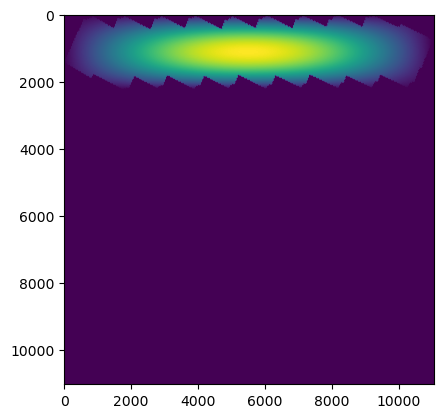

In [6]:
hers = hers_obj.maps[name]
hers_mask = hers_obj.masks[name]
hd_hers = hers_obj.headers[name]
pix_arcsec = hers_obj.pix_sizes_arcsec[name]
plt.imshow(hers_mask);
print(np.shape(hers))
print('pixel size = {0:0.2f} arcsec'.format(pix_arcsec))

In [8]:
k_psw=get_k_from_map(hers,pix_arcsec)
fft_hers = get_twod_fft(hers, pix_arcsec=pix_arcsec)
ell_bins_hers = get_ell_bins(hers, pix_arcsec, deltal=deltal, width=width)
pk_hers_tst, ell_hers_tst = bin_in_rings(fft_hers, ell_bins_hers, k_psw)
k_theta_hers0 = ell_to_k((ell_bins_hers[1:]+ell_bins_hers[0:-1])/2)
k_theta_hers = ell_to_k(ell_hers_tst)

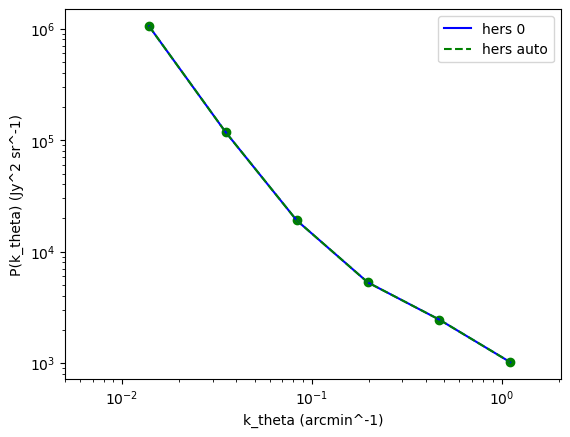

In [10]:
plt.scatter(k_theta_hers, pk_hers_tst, c='g')
plt.plot(k_theta_hers0, pk_hers_tst, '-',c='b', label='hers 0')
plt.plot(k_theta_hers, pk_hers_tst, '--', c='g', label='hers auto')
plt.xlim([0.005,2.05])
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right');
plt.xlabel('k_theta (arcmin^-1)');
plt.ylabel('P(k_theta) (Jy^2 sr^-1)');

In [14]:
filename_pks = 'pks__{0}_layers__width_{1:0.02f}__deltal_{2:0.0f}.pkl'.format(len(map_bins),width,deltal)
pkpicklepath = os.path.join(path_hetdex_maps,'mkks',filename_pks)
print(pkpicklepath)
print(os.path.isfile(pkpicklepath))

/Users/mviero/data/Astronomy/maps/cutouts/layers/mkks/pks__9_layers__width_0.75__deltal_300.pkl
False


In [16]:
if os.path.isfile(pkpicklepath):
    # IMPORT PICKLE 
    print('Importing {}'.format(pkpicklepath))
    with open(pkpicklepath, "rb") as file_path:
        pk_dict = pickle.load(file_path)
else:
    wvs = ['PSW','PMW','PLW']
    fft_dict = {}
    pk_dict = {}
    for iwv, wv1 in enumerate(wvs): 

        fft_dict[wv1] = {}
        pk_dict[wv1] = {}
        
        hers = hers_obj.maps[wv1] / spire_solid_angle[iwv] * hipe_8_11_calibration_correction[iwv] * spire_color_correction[iwv]
        hers_mask = hers_obj.masks[wv1]
        pix_arcsec = hers_obj.pix_sizes_arcsec[wv1]
        print('pixsize={0:0.2f}arcsec'.format(pix_arcsec))
        
        dims = np.shape(hers_mask)
        #fsky = (np.product(dims) * (pix_arcsec / 3600 / 180 * np.pi)**2) / (4 * np.pi)
        #zero_factor_hers = 1 - np.sum(hers_mask==0)/np.prod(dims)
        #print('fsky={0:0.2e}'.format(fsky))
        #print('zero_factor_hers={0:0.3f}'.format(zero_factor_hers))

        k_map=get_k_from_map(hers,pix_arcsec)
        ell_bins = get_ell_bins(hers, pix_arcsec, deltal=deltal, width=width)

        fft_dict[wv1]['fft_hers'] = get_twod_ifft(hers*hers_mask, hers*hers_mask, pix_arcsec=pix_arcsec)
        pk_dict[wv1]['pk_hers'], pk_dict[wv1]['ell_hers'] = bin_in_rings(fft_dict[wv1]['fft_hers'], ell_bins, k_map)
        #pk_dict[wv1]['pkc_hers'] = 1/zero_factor_hers * bin_in_rings(fft_dict[wv1]['fft_hers'], ell_bins, k_map)

        for ilayer, hetdex_map_bin in enumerate(map_bins):
            xcorr_label = '_x_'.join([wv1,hetdex_map_bin])
            fft_dict[wv1][xcorr_label] = {}
            pk_dict[wv1][xcorr_label] = {}   
            if not ilayer:
                hetdex_mask_path = os.path.join(path_hetdex_maps,'hetdex_footprint_mask','hetdex_mask__cea'+map_pix_key_dict[wv1]+'.fits')
                hetdex_mask, hdm_hetdex = fits.getdata(hetdex_mask_path, 0, header=True)
                #zero_factor_hers_x_hetdex = 1 - (np.sum(hers_mask==0)+np.sum(hetdex_mask==0))/2/np.prod(dims)
                #zero_factor_hetdex = 1 - np.sum(hetdex_mask==0)/np.prod(dims)
                #print('zero_factor_hetdex={0:0.2e}'.format(zero_factor_hetdex))
                #print('zero_factor_hersXhetdex={0:0.2e}'.format(zero_factor_hers_x_hetdex))
            print('Estimating {}'.format(xcorr_label))

            hetdex_bin_path = os.path.join(path_hetdex_layers,hetdex_map_bin+map_key_dict[wv1]+'.fits')
            hetdex, hd_hetdex = fits.getdata(hetdex_bin_path, 0, header=True)
            hetdex = hetdex / spire_solid_angle[iwv] * hipe_8_11_calibration_correction[iwv] * spire_color_correction[iwv]
            
            fft_dict[wv1][xcorr_label]['fft_hers_x_hetdex'] = get_twod_ifft(hers*hers_mask, map_two=hetdex*hetdex_mask, pix_arcsec=pix_arcsec)
            fft_dict[wv1][xcorr_label]['fft_hetdex'] = get_twod_ifft(hetdex*hetdex_mask, pix_arcsec=pix_arcsec)

            pk_dict[wv1][xcorr_label]['pk_hers_x_hetdex'],pk_dict[wv1][xcorr_label]['ell_hers_x_hetdex'] = bin_in_rings(fft_dict[wv1][xcorr_label]['fft_hers_x_hetdex'], ell_bins, k_map)
            pk_dict[wv1][xcorr_label]['pk_hetdex'],pk_dict[wv1][xcorr_label]['ell_hetdex'] = bin_in_rings(fft_dict[wv1][xcorr_label]['fft_hetdex'], ell_bins, k_map)
            #pk_dict[wv1][xcorr_label]['pkc_hers_x_hetdex'] = 1/zero_factor_hers_x_hetdex * bin_in_rings(fft_dict[wv1][xcorr_label]['fft_hers_x_hetdex'], ell_bins, k_map)
            #pk_dict[wv1][xcorr_label]['pkc_hetdex'] = 1/zero_factor_hetdex * bin_in_rings(fft_dict[wv1][xcorr_label]['fft_hetdex'], ell_bins, k_map)
    
    # Save pickle
    try:
        #with open(fftpicklepath, "wb") as pickle_file_path:
        #    pickle.dump(fft_dict, pickle_file_path)
        with open(pkpicklepath, "wb") as pickle_file_path:
            pickle.dump(pk_dict, pickle_file_path)
    except:
        print("Something wrong with save directory??")
        pdb.set_trace()

pixsize=7.43arcsec
Estimating PSW_x_redshift_1p8_2p3__magnitude_20_22
Estimating PSW_x_redshift_1p8_2p3__magnitude_22_24
Estimating PSW_x_redshift_1p8_2p3__magnitude_24_30
Estimating PSW_x_redshift_2p3_2p9__magnitude_20_22
Estimating PSW_x_redshift_2p3_2p9__magnitude_22_24
Estimating PSW_x_redshift_2p3_2p9__magnitude_24_30
Estimating PSW_x_redshift_2p9_3p5__magnitude_20_22
Estimating PSW_x_redshift_2p9_3p5__magnitude_22_24
Estimating PSW_x_redshift_2p9_3p5__magnitude_24_30
pixsize=9.90arcsec
Estimating PMW_x_redshift_1p8_2p3__magnitude_20_22
Estimating PMW_x_redshift_1p8_2p3__magnitude_22_24
Estimating PMW_x_redshift_1p8_2p3__magnitude_24_30
Estimating PMW_x_redshift_2p3_2p9__magnitude_20_22
Estimating PMW_x_redshift_2p3_2p9__magnitude_22_24
Estimating PMW_x_redshift_2p3_2p9__magnitude_24_30
Estimating PMW_x_redshift_2p9_3p5__magnitude_20_22
Estimating PMW_x_redshift_2p9_3p5__magnitude_22_24
Estimating PMW_x_redshift_2p9_3p5__magnitude_24_30
pixsize=14.85arcsec
Estimating PLW_x_redshif

In [17]:
filename_mkk = 'mkk__{0}_layers__width_{1:0.02f}__deltal_{2:0.0f}.pkl'.format(len(map_bins),width,deltal)
fpicklepath = os.path.join(path_hetdex_maps,'mkks',filename_mkk)
print(fpicklepath)
print(os.path.isfile(fpicklepath))

/Users/mviero/data/Astronomy/maps/cutouts/layers/mkks/mkk__9_layers__width_0.75__deltal_300.pkl
False


In [18]:
if os.path.isfile(fpicklepath):
    # IMPORT PICKLE 
    print('Importing {}'.format(fpicklepath))
    with open(fpicklepath, "rb") as file_path:
        mkk_dict = pickle.load(file_path)
else:
    wvs = ['PSW','PMW','PLW']
    mkk_dict = {}
    for iwv, wv1 in enumerate(wvs): 

        mkk_dict[wv1] = {}
        hers_mask = hers_obj.masks[wv1]
        pix_arcsec = hers_obj.pix_sizes_arcsec[wv1]

        ell_bins, hers_mask_pk = get_mc_mkk(hers_mask, hers_mask, pix_arcsec, deltal=deltal, width=width)
        mkk_dict[wv1]['hers_mkk'] = np.linalg.inv(hers_mask_pk)

        for hetdex_map_bin in map_bins:
            xcorr_label = '_x_'.join([wv1,hetdex_map_bin])
            mkk_dict[wv1][xcorr_label] = {}
            print('Estimating MKK of {}'.format(xcorr_label))

            hetdex_mask_path = os.path.join(path_hetdex_maps,'hetdex_footprint_mask','hetdex_mask__cea'+map_key_dict[wv1]+'.fits')
            hetdex_all, hd_hetdex = fits.getdata(hetdex_mask_path, 0, header=True)
            ind_zero = hetdex_all == 0
            hetdex_mask = np.ones_like(hetdex_all)
            hetdex_mask[ind_zero] = 0
            np.shape(hers_mask)
            np.shape(hetdex_mask)
            #pdb.set_trace()

            tst_ell, hers_x_hetdex_mask_pk = get_mc_mkk(hers_mask, hetdex_mask, pix_arcsec, deltal=deltal, width=width)
            mkk_dict[wv1][xcorr_label]['hers_x_hetdex_mkk']=np.linalg.inv(hers_x_hetdex_mask_pk)
            tst_ell, hetdex_mask_pk = get_mc_mkk(hetdex_mask, hetdex_mask, pix_arcsec, deltal=deltal, width=width)
            mkk_dict[wv1][xcorr_label]['hetdex_mkk']=np.linalg.inv(hetdex_mask_pk)
    
    # Save pickle
    try:
        with open(fpicklepath, "wb") as pickle_file_path:
            pickle.dump(mkk_dict, pickle_file_path)
    except:
        print("Something wrong with save directory??")
        pdb.set_trace()

Estimating MKK of PSW_x_redshift_1p8_2p3__magnitude_20_22
Estimating MKK of PSW_x_redshift_1p8_2p3__magnitude_22_24
Estimating MKK of PSW_x_redshift_1p8_2p3__magnitude_24_30
Estimating MKK of PSW_x_redshift_2p3_2p9__magnitude_20_22
Estimating MKK of PSW_x_redshift_2p3_2p9__magnitude_22_24
Estimating MKK of PSW_x_redshift_2p3_2p9__magnitude_24_30
Estimating MKK of PSW_x_redshift_2p9_3p5__magnitude_20_22
Estimating MKK of PSW_x_redshift_2p9_3p5__magnitude_22_24
Estimating MKK of PSW_x_redshift_2p9_3p5__magnitude_24_30
Estimating MKK of PMW_x_redshift_1p8_2p3__magnitude_20_22
Estimating MKK of PMW_x_redshift_1p8_2p3__magnitude_22_24
Estimating MKK of PMW_x_redshift_1p8_2p3__magnitude_24_30
Estimating MKK of PMW_x_redshift_2p3_2p9__magnitude_20_22
Estimating MKK of PMW_x_redshift_2p3_2p9__magnitude_22_24
Estimating MKK of PMW_x_redshift_2p3_2p9__magnitude_24_30
Estimating MKK of PMW_x_redshift_2p9_3p5__magnitude_20_22
Estimating MKK of PMW_x_redshift_2p9_3p5__magnitude_22_24
Estimating MKK

In [25]:
pk_dict['PSW'].keys()

dict_keys(['pk_hers', 'ell_hers', 'PSW_x_redshift_1p8_2p3__magnitude_20_22', 'PSW_x_redshift_1p8_2p3__magnitude_22_24', 'PSW_x_redshift_1p8_2p3__magnitude_24_30', 'PSW_x_redshift_2p3_2p9__magnitude_20_22', 'PSW_x_redshift_2p3_2p9__magnitude_22_24', 'PSW_x_redshift_2p3_2p9__magnitude_24_30', 'PSW_x_redshift_2p9_3p5__magnitude_20_22', 'PSW_x_redshift_2p9_3p5__magnitude_22_24', 'PSW_x_redshift_2p9_3p5__magnitude_24_30'])

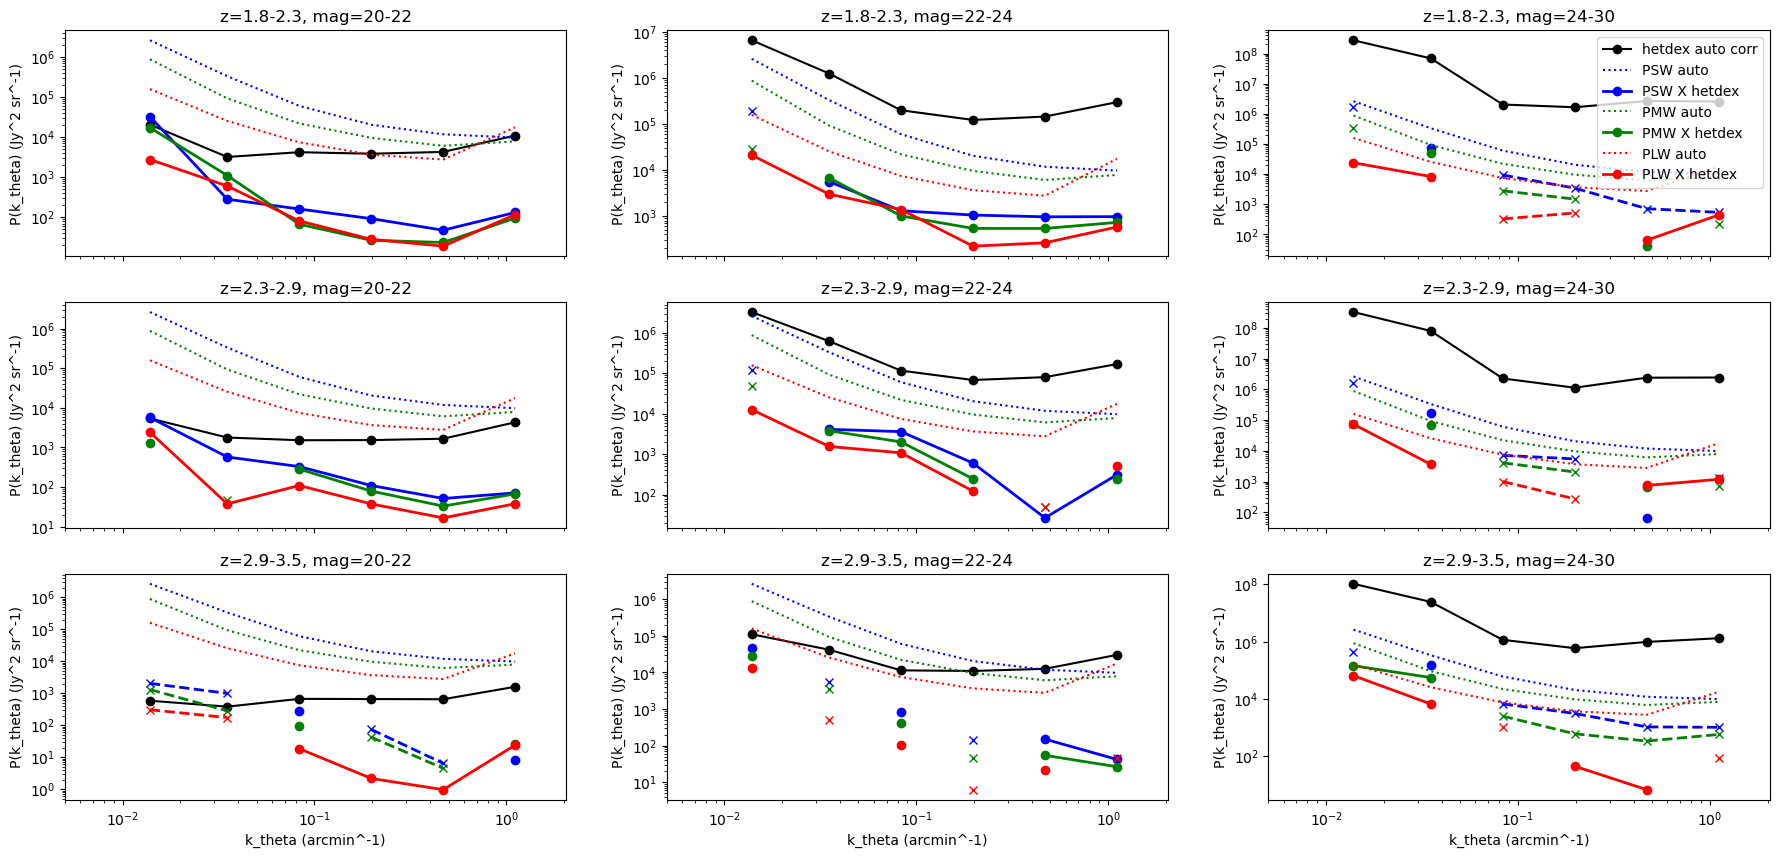

In [22]:
xs=3
ys=3
fig, axs = plt.subplots(xs, ys, figsize=(22, 10))
color=['b','g','r']
multfac = 1
for i, hetdex_map_bin in enumerate(map_bins):
    ii = i//xs
    iii = np.mod(i,ys)
    
    for iwv, wv1 in enumerate(wvs):
        xcorr_label = '_x_'.join([wv1,hetdex_map_bin])
        sav_label = 'x'.join([map_sav[wv1],map_sav[wv1]])

        ell = pk_dict[wv1]['ell_hers']
        #ell_hetdex = pk_dict[wv1][xcorr_label]['ell_hetdex']
        k_theta = ell_to_k(ell)

        Bl = get_psf_correction(ell, map_psf[wv1])
        
        # Raw Power Spectra
        pk_hers = pk_dict[wv1]['pk_hers'] 
        pk_hetdex = pk_dict[wv1][xcorr_label]['pk_hetdex'] 
        pk_hers_x_hetdex = pk_dict[wv1][xcorr_label]['pk_hers_x_hetdex'] 
        
        # Mode-Coupling Matricies
        hers_mkk = mkk_dict[wv1]['hers_mkk']
        hetdex_mkk = mkk_dict[wv1][xcorr_label]['hetdex_mkk']
        hers_x_hetdex_mkk = mkk_dict[wv1][xcorr_label]['hers_x_hetdex_mkk']
        
        # HETDEX auto
        if not iwv:
            #axs[ii,iii].plot(k_theta, multfac * pk_hetdex/Bl, '--o', c='k', label='hetdex auto raw')
            axs[ii,iii].plot(k_theta, multfac * np.matmul(pk_hetdex, hetdex_mkk)/Bl, '-o', c='k', label='hetdex auto corr')
        
        # HerS auto
        axs[ii,iii].plot(k_theta, multfac * np.matmul(pk_hers, hers_mkk)/Bl, ':', c=color[iwv], label='{} auto'.format(wv1))
        
        # HETDEX x HerS
        y_Hxh = multfac * (np.sqrt(np.matmul(pk_hers_x_hetdex, hers_x_hetdex_mkk))**2)/Bl
        y_Hxh_n = multfac * (np.sqrt(-np.matmul(pk_hers_x_hetdex, hers_x_hetdex_mkk))**2)/Bl
        axs[ii,iii].plot(k_theta, y_Hxh,'-o', lw=2, c=color[iwv], label='{} X hetdex'.format(wv1));
        axs[ii,iii].plot(k_theta, y_Hxh_n,'--x', lw=2, c=color[iwv]);

        # VIERO 2012
        path_v12 = os.path.join(path_sav, file_sav+sav_label+'.sav')
        if os.path.isfile(path_v12):
            x = readsav(path_v12)
            y = x['combined_spectra'][:,0,0]
            #axs[ii,iii].plot(x['k_t'], y, 's', c=color[iwv], label=None)
        else:
            print('No file found {}'.format(path_v12))
        
        #axs[ii,iii].set_ylim([1e2,4e5])
        axs[ii,iii].set_xlim([0.005,2.05])
        axs[ii,iii].set_xscale('log')
        axs[ii,iii].set_yscale('log')
        axs[ii,iii].set_title(xcorr_label.split('_x_')[1].replace('p','.').replace('redshift_','z=').replace('__magnitude_',', mag=').replace('_','-'))
        axs[ii,iii].set_ylabel('P(k_theta) (Jy^2 sr^-1)')
        
        if iii==2 and not ii:
            axs[ii,iii].legend(loc='upper right');   
            
        if ii < ys-1:
            axs[ii,iii].set_xticklabels([])
        else:
            axs[ii,iii].set_xlabel('k_theta (arcmin^-1)')
        
         

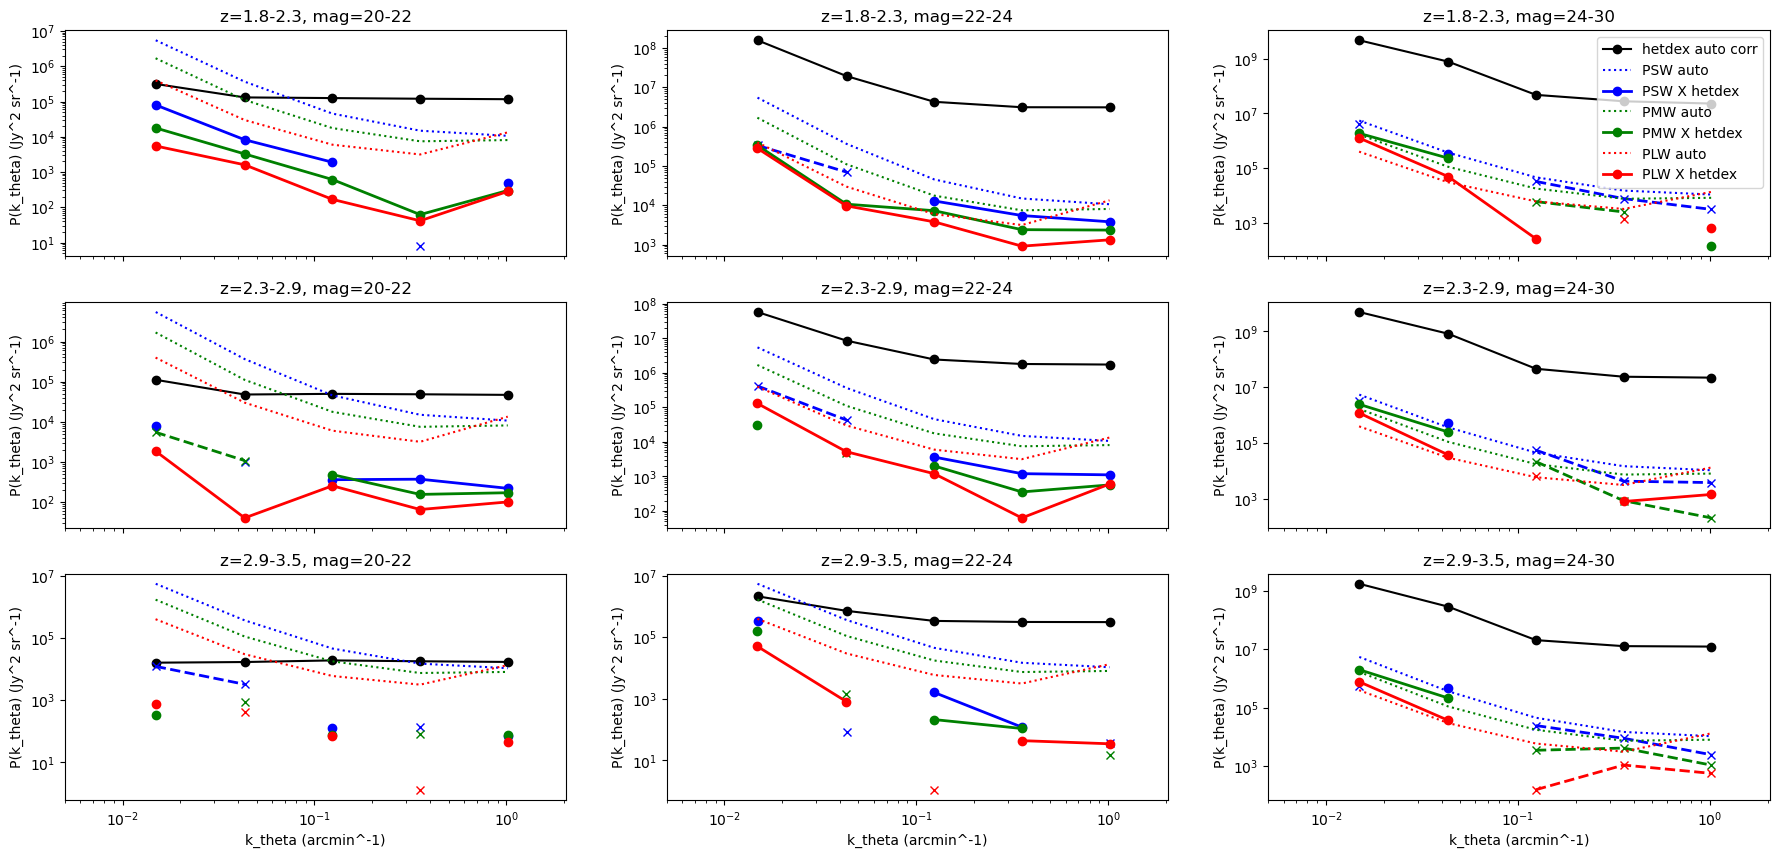

In [41]:
xs=3
ys=3
fig, axs = plt.subplots(xs, ys, figsize=(22, 10))
color=['b','g','r']
multfac = 1
for i, hetdex_map_bin in enumerate(map_bins):
    ii = i//xs
    iii = np.mod(i,ys)
    
    for iwv, wv1 in enumerate(wvs):
        xcorr_label = '_x_'.join([wv1,hetdex_map_bin])
        sav_label = 'x'.join([map_sav[wv1],map_sav[wv1]])
        Bl = get_psf_correction(ell, map_psf[wv1])

        ell = pk_dict[wv1]['ell_hers']
        #ell_hetdex = pk_dict[wv1][xcorr_label]['ell_hetdex']
        k_theta = ell_to_k(ell)
        
        # Raw Power Spectra
        pk_hers = pk_dict[wv1]['pk_hers'] 
        pk_hetdex = pk_dict[wv1][xcorr_label]['pk_hetdex'] 
        pk_hers_x_hetdex = pk_dict[wv1][xcorr_label]['pk_hers_x_hetdex'] 
        
        # Mode-Coupling Matricies
        hers_mkk = mkk_dict[wv1]['hers_mkk']
        hetdex_mkk = mkk_dict[wv1][xcorr_label]['hetdex_mkk']
        hers_x_hetdex_mkk = mkk_dict[wv1][xcorr_label]['hers_x_hetdex_mkk']
        
        # HETDEX auto
        if not iwv:
            #axs[ii,iii].plot(k_theta, multfac * pk_hetdex/Bl, '--o', c='k', label='hetdex auto raw')
            axs[ii,iii].plot(k_theta, multfac * np.matmul(pk_hetdex, hetdex_mkk)/Bl, '-o', c='k', label='hetdex auto corr')
        
        # HerS auto
        axs[ii,iii].plot(k_theta, multfac * np.matmul(pk_hers, hers_mkk)/Bl, ':', c=color[iwv], label='{} auto'.format(wv1))
        
        # HETDEX x HerS
        y_Hxh = multfac * (np.sqrt(np.matmul(pk_hers_x_hetdex, hers_x_hetdex_mkk))**2)/Bl
        y_Hxh_n = multfac * (np.sqrt(-np.matmul(pk_hers_x_hetdex, hers_x_hetdex_mkk))**2)/Bl
        axs[ii,iii].plot(k_theta, y_Hxh,'-o', lw=2, c=color[iwv], label='{} X hetdex'.format(wv1));
        axs[ii,iii].plot(k_theta, y_Hxh_n,'--x', lw=2, c=color[iwv]);

        # VIERO 2012
        path_v12 = os.path.join(path_sav, file_sav+sav_label+'.sav')
        if os.path.isfile(path_v12):
            x = readsav(path_v12)
            y = x['combined_spectra'][:,0,0]
            #axs[ii,iii].plot(x['k_t'], y, 's', c=color[iwv], label=None)
        else:
            print('No file found {}'.format(path_v12))
        
        #axs[ii,iii].set_ylim([1e2,4e5])
        axs[ii,iii].set_xlim([0.005,2.05])
        axs[ii,iii].set_xscale('log')
        axs[ii,iii].set_yscale('log')
        axs[ii,iii].set_title(xcorr_label.split('_x_')[1].replace('p','.').replace('redshift_','z=').replace('__magnitude_',', mag=').replace('_','-'))
        axs[ii,iii].set_ylabel('P(k_theta) (Jy^2 sr^-1)')
        
        if iii==2 and not ii:
            axs[ii,iii].legend(loc='upper right');   
            
        if ii < ys-1:
            axs[ii,iii].set_xticklabels([])
        else:
            axs[ii,iii].set_xlabel('k_theta (arcmin^-1)')
        
         

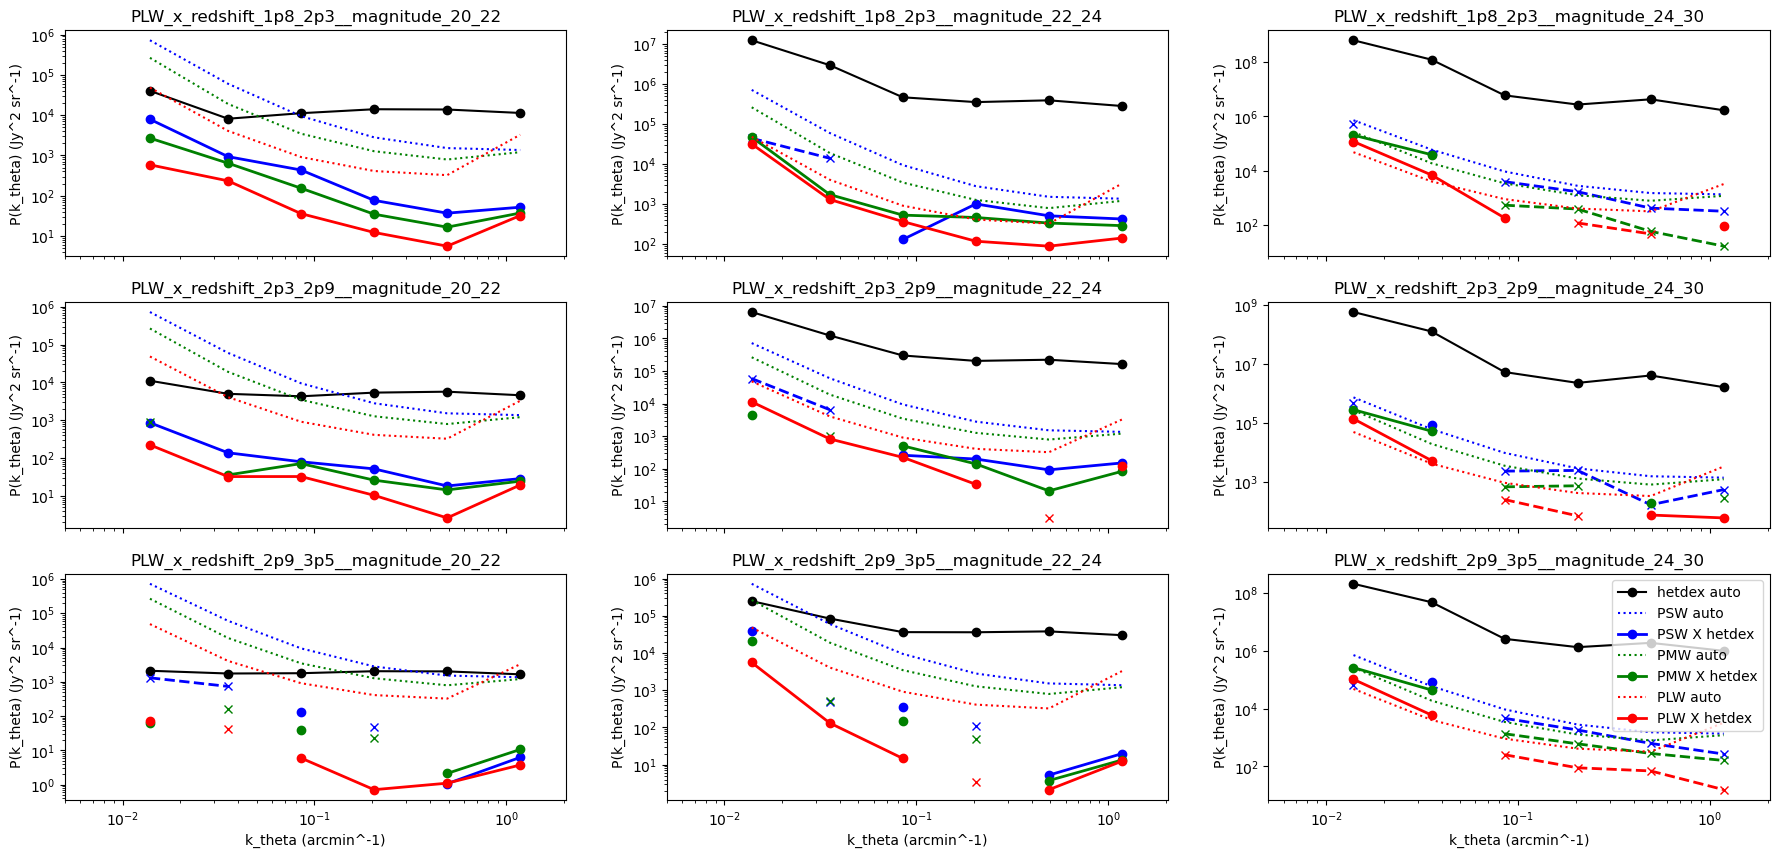

In [18]:
xs=3
ys=3
ell = (ell_bins[1:]+ell_bins[0:-1])/2
k_theta = ell_to_k(ell)
fig, axs = plt.subplots(xs, ys, figsize=(22, 10))
color=['b','g','r']
for i, hetdex_map_bin in enumerate(map_bins):
    ii = i//xs
    iii = np.mod(i,ys)
    
    for iwv, wv1 in enumerate(wvs):
        xcorr_label = '_x_'.join([wv1,hetdex_map_bin])
        Bl = get_psf_correction(ell, map_psf[wv1])
        
        pk_hers = pk_dict[wv1]['pk_hers'] 
        pk_hetdex = pk_dict[wv1][xcorr_label]['pk_hetdex'] 
        pk_hers_x_hetdex = pk_dict[wv1][xcorr_label]['pk_hers_x_hetdex'] 
        hers_mkk = mkk_dict[wv1]['hers_mkk']
        hetdex_mkk = mkk_dict[wv1][xcorr_label]['hetdex_mkk']
        hers_x_hetdex_mkk = mkk_dict[wv1][xcorr_label]['hers_x_hetdex_mkk']
        
        if not iwv:
            axs[ii,iii].plot(k_theta, np.matmul(pk_hetdex, hetdex_mkk)/Bl, '-o', c='k', label='hetdex auto')
        axs[ii,iii].plot(k_theta, np.matmul(pk_hers, hers_mkk)/Bl, ':', c=color[iwv], label='{} auto'.format(wv1))
        y_Hxh = (np.sqrt(np.matmul(pk_hers_x_hetdex, hers_x_hetdex_mkk))**2)/Bl
        y_Hxh_n = (np.sqrt(-np.matmul(pk_hers_x_hetdex, hers_x_hetdex_mkk))**2)/Bl
        axs[ii,iii].plot(k_theta, y_Hxh,'-o', lw=2, c=color[iwv], label='{} X hetdex'.format(wv1));
        axs[ii,iii].plot(k_theta, y_Hxh_n,'--x', lw=2, c=color[iwv]);

        #axs[ii,iii].set_ylim([1e2,4e5])
        axs[ii,iii].set_xlim([0.005,2.05])
        axs[ii,iii].set_xscale('log')
        axs[ii,iii].set_yscale('log')
        axs[ii,iii].set_title(xcorr_label)
        axs[ii,iii].set_ylabel('P(k_theta) (Jy^2 sr^-1)')
        
        if ii < ys-1:
            axs[ii,iii].set_xticklabels([])
        else:
            axs[ii,iii].set_xlabel('k_theta (arcmin^-1)')
            
plt.legend(loc='upper right');            

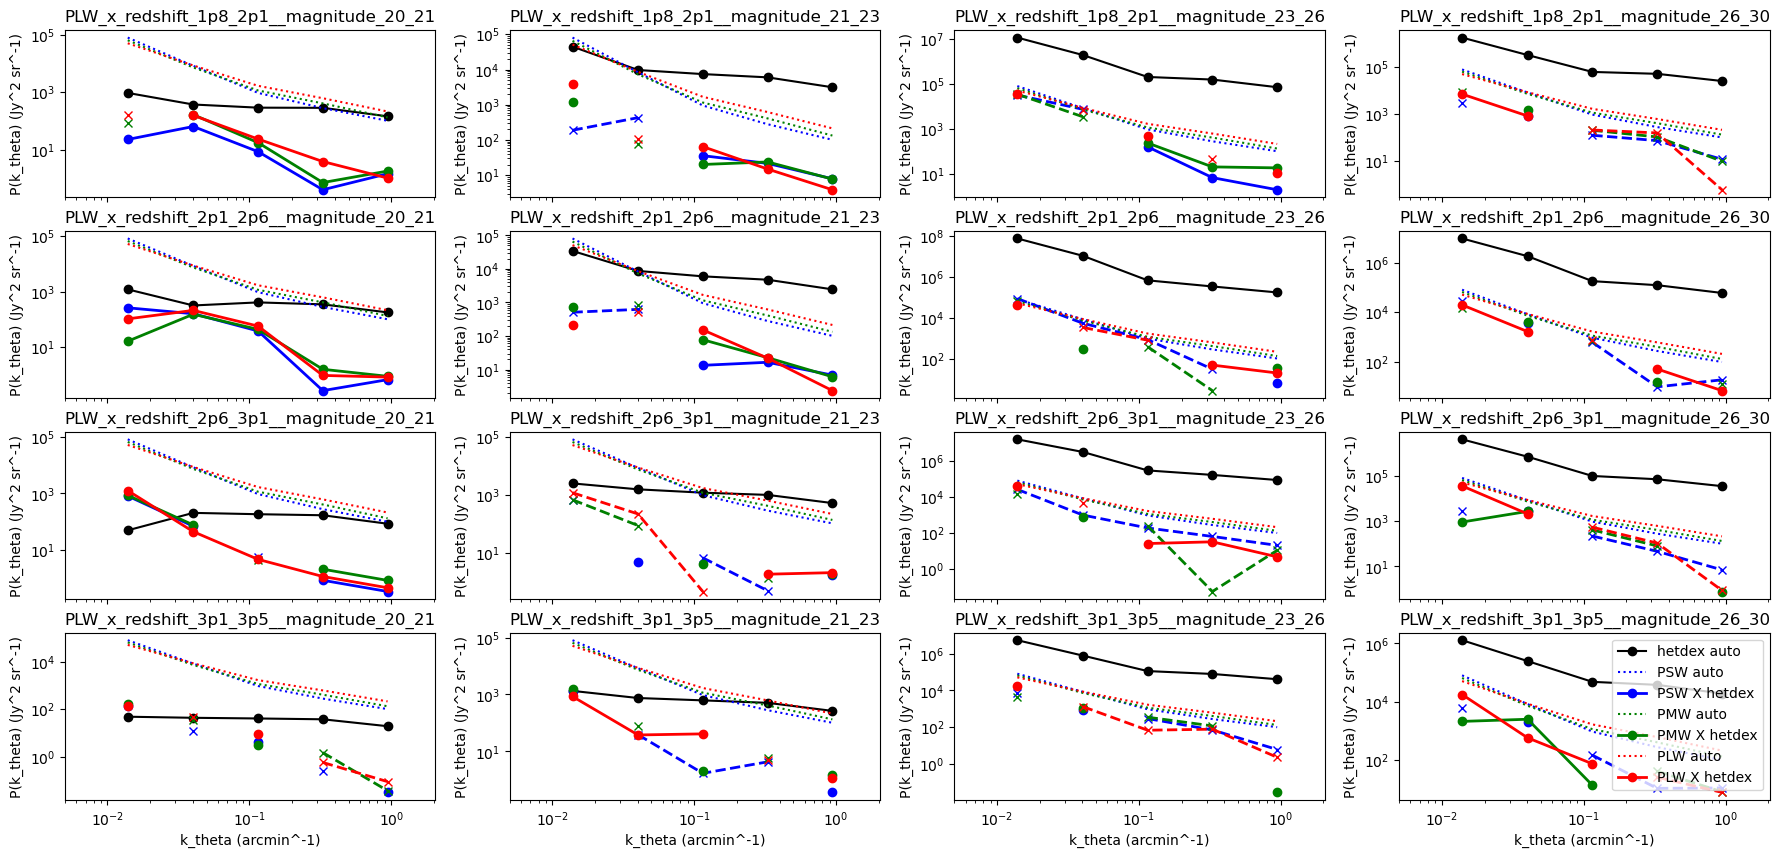

In [11]:
xs=4
ys=4
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
fig, axs = plt.subplots(xs, ys, figsize=(22, 10))
color=['b','g','r']
for i, hetdex_map_bin in enumerate(map_bins):
    ii = i//xs
    iii = np.mod(i,ys)
    
    for iwv, wv1 in enumerate(wvs):
        xcorr_label = '_x_'.join([wv1,hetdex_map_bin])
        
        pk_hers = pk_dict[wv1]['pk_hers'] 
        pk_hetdex = pk_dict[wv1][xcorr_label]['pk_hetdex'] 
        pk_hers_x_hetdex = pk_dict[wv1][xcorr_label]['pk_hers_x_hetdex'] 
        hers_mkk = mkk_dict[wv1]['hers_mkk']
        hetdex_mkk = mkk_dict[wv1][xcorr_label]['hetdex_mkk']
        hers_x_hetdex_mkk = mkk_dict[wv1][xcorr_label]['hers_x_hetdex_mkk']
        
        if not iwv:
            axs[ii,iii].plot(k_theta, np.matmul(pk_hetdex, hetdex_mkk), '-o', c='k', label='hetdex auto')
        axs[ii,iii].plot(k_theta, np.matmul(pk_hers, hers_mkk), ':', c=color[iwv], label='{} auto'.format(wv1))
        y_Hxh = np.sqrt(np.matmul(pk_hers_x_hetdex, hers_x_hetdex_mkk))**2
        y_Hxh_n = np.sqrt(-np.matmul(pk_hers_x_hetdex, hers_x_hetdex_mkk))**2
        axs[ii,iii].plot(k_theta, y_Hxh,'-o', lw=2, c=color[iwv], label='{} X hetdex'.format(wv1));
        axs[ii,iii].plot(k_theta, y_Hxh_n,'--x', lw=2, c=color[iwv]);

        #axs[ii,iii].set_ylim([1e2,4e5])
        axs[ii,iii].set_xlim([0.005,2.05])
        axs[ii,iii].set_xscale('log')
        axs[ii,iii].set_yscale('log')
        axs[ii,iii].set_title(xcorr_label)
        axs[ii,iii].set_ylabel('P(k_theta) (Jy^2 sr^-1)')
        
        if ii < ys-1:
            axs[ii,iii].set_xticklabels([])
        else:
            axs[ii,iii].set_xlabel('k_theta (arcmin^-1)')
            
plt.legend(loc='upper right');            

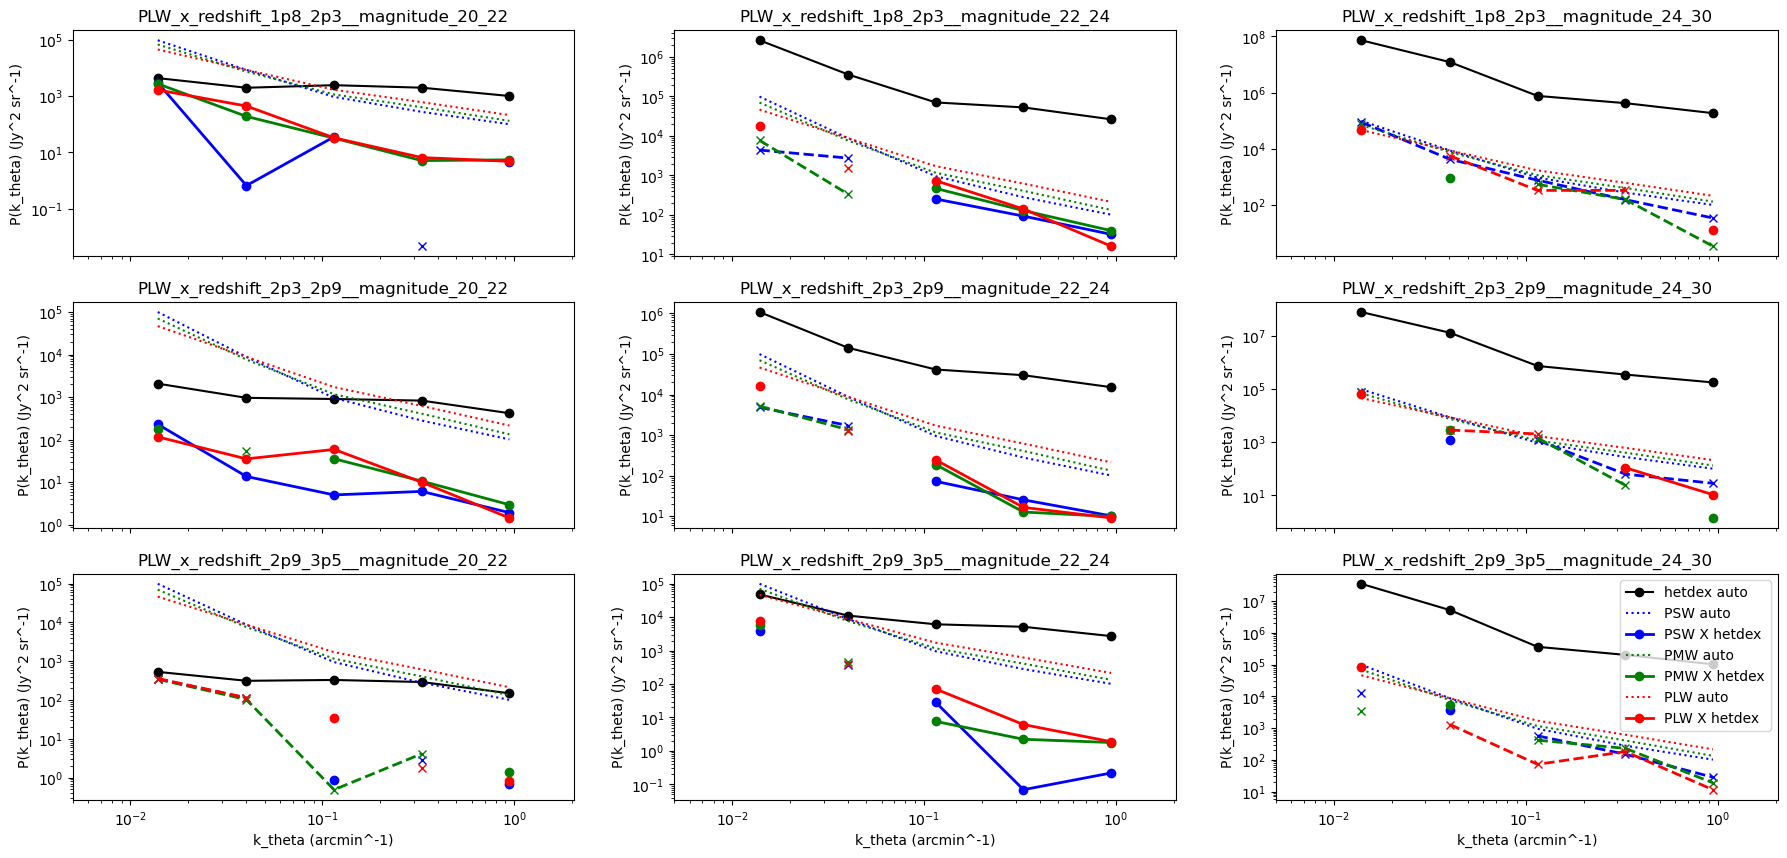

In [47]:
xs=3
ys=3
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
fig, axs = plt.subplots(xs, ys, figsize=(22, 10))
color=['b','g','r']
for i, hetdex_map_bin in enumerate(map_bins):
    ii = i//xs
    iii = np.mod(i,ys)
    
    for iwv, wv1 in enumerate(wvs):
        xcorr_label = '_x_'.join([wv1,hetdex_map_bin])
        
        pk_hers = pk_dict[wv1]['pk_hers'] 
        pk_hetdex = pk_dict[wv1][xcorr_label]['pk_hetdex'] 
        pk_hers_x_hetdex = pk_dict[wv1][xcorr_label]['pk_hers_x_hetdex'] 
        hers_mkk = mkk_dict[wv1]['hers_mkk']
        hetdex_mkk = mkk_dict[wv1][xcorr_label]['hetdex_mkk']
        hers_x_hetdex_mkk = mkk_dict[wv1][xcorr_label]['hers_x_hetdex_mkk']
        
        if not iwv:
            axs[ii,iii].plot(k_theta, np.matmul(pk_hetdex, hetdex_mkk), '-o', c='k', label='hetdex auto')
        axs[ii,iii].plot(k_theta, np.matmul(pk_hers, hers_mkk), ':', c=color[iwv], label='{} auto'.format(wv1))
        y_Hxh = np.sqrt(np.matmul(pk_hers_x_hetdex, hers_x_hetdex_mkk))**2
        y_Hxh_n = np.sqrt(-np.matmul(pk_hers_x_hetdex, hers_x_hetdex_mkk))**2
        axs[ii,iii].plot(k_theta, y_Hxh,'-o', lw=2, c=color[iwv], label='{} X hetdex'.format(wv1));
        axs[ii,iii].plot(k_theta, y_Hxh_n,'--x', lw=2, c=color[iwv]);

        #axs[ii,iii].set_ylim([1e2,4e5])
        axs[ii,iii].set_xlim([0.005,2.05])
        axs[ii,iii].set_xscale('log')
        axs[ii,iii].set_yscale('log')
        axs[ii,iii].set_title(xcorr_label)
        axs[ii,iii].set_ylabel('P(k_theta) (Jy^2 sr^-1)')
        
        if ii < ys-1:
            axs[ii,iii].set_xticklabels([])
        else:
            axs[ii,iii].set_xlabel('k_theta (arcmin^-1)')
            
plt.legend(loc='upper right');            

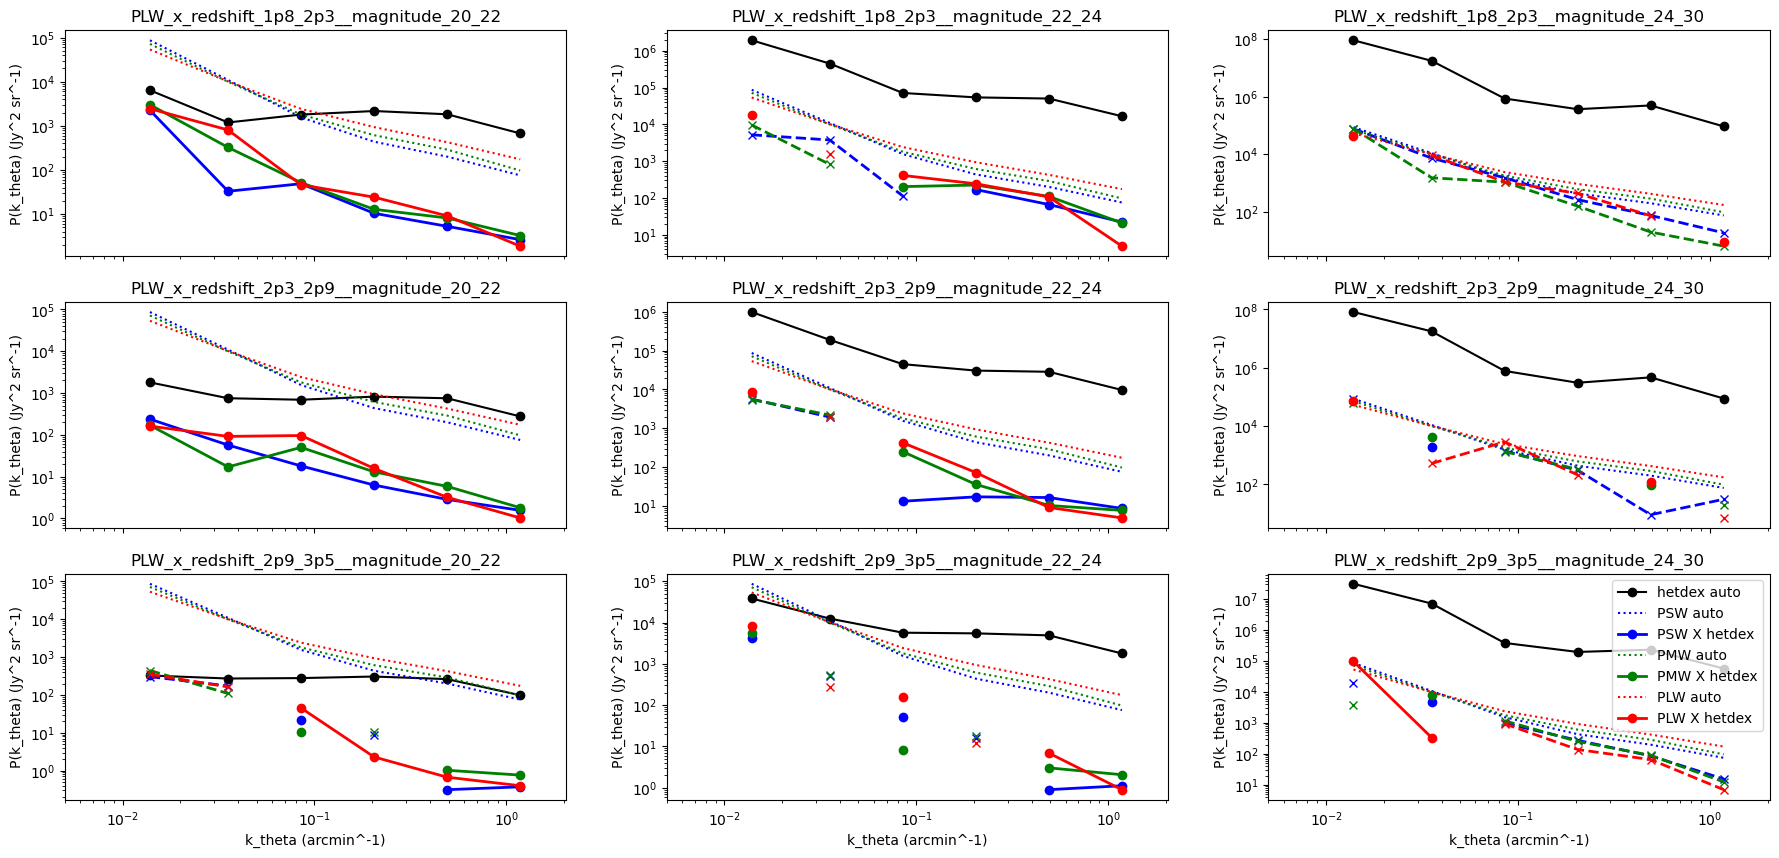

In [32]:
xs=3
ys=3
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
fig, axs = plt.subplots(xs, ys, figsize=(22, 10))
color=['b','g','r']
for i, hetdex_map_bin in enumerate(map_bins):
    ii = i//xs
    iii = np.mod(i,ys)
    
    for iwv, wv1 in enumerate(wvs):
        xcorr_label = '_x_'.join([wv1,hetdex_map_bin])
        
        pk_hers = pk_dict[wv1]['pk_hers'] 
        pk_hetdex = pk_dict[wv1][xcorr_label]['pk_hetdex'] 
        pk_hers_x_hetdex = pk_dict[wv1][xcorr_label]['pk_hers_x_hetdex'] 
        hers_mkk = mkk_dict[wv1]['hers_mkk']
        hetdex_mkk = mkk_dict[wv1][xcorr_label]['hetdex_mkk']
        hers_x_hetdex_mkk = mkk_dict[wv1][xcorr_label]['hers_x_hetdex_mkk']
        
        if not iwv:
            axs[ii,iii].plot(k_theta, np.matmul(pk_hetdex, hetdex_mkk), '-o', c='k', label='hetdex auto')
        axs[ii,iii].plot(k_theta, np.matmul(pk_hers, hers_mkk), ':', c=color[iwv], label='{} auto'.format(wv1))
        y_Hxh = np.sqrt(np.matmul(pk_hers_x_hetdex, hers_x_hetdex_mkk))**2
        y_Hxh_n = np.sqrt(-np.matmul(pk_hers_x_hetdex, hers_x_hetdex_mkk))**2
        axs[ii,iii].plot(k_theta, y_Hxh,'-o', lw=2, c=color[iwv], label='{} X hetdex'.format(wv1));
        axs[ii,iii].plot(k_theta, y_Hxh_n,'--x', lw=2, c=color[iwv]);

        #axs[ii,iii].set_ylim([1e2,4e5])
        axs[ii,iii].set_xlim([0.005,2.05])
        axs[ii,iii].set_xscale('log')
        axs[ii,iii].set_yscale('log')
        axs[ii,iii].set_title(xcorr_label)
        axs[ii,iii].set_ylabel('P(k_theta) (Jy^2 sr^-1)')
        
        if ii < ys-1:
            axs[ii,iii].set_xticklabels([])
        else:
            axs[ii,iii].set_xlabel('k_theta (arcmin^-1)')
            
plt.legend(loc='upper right');            

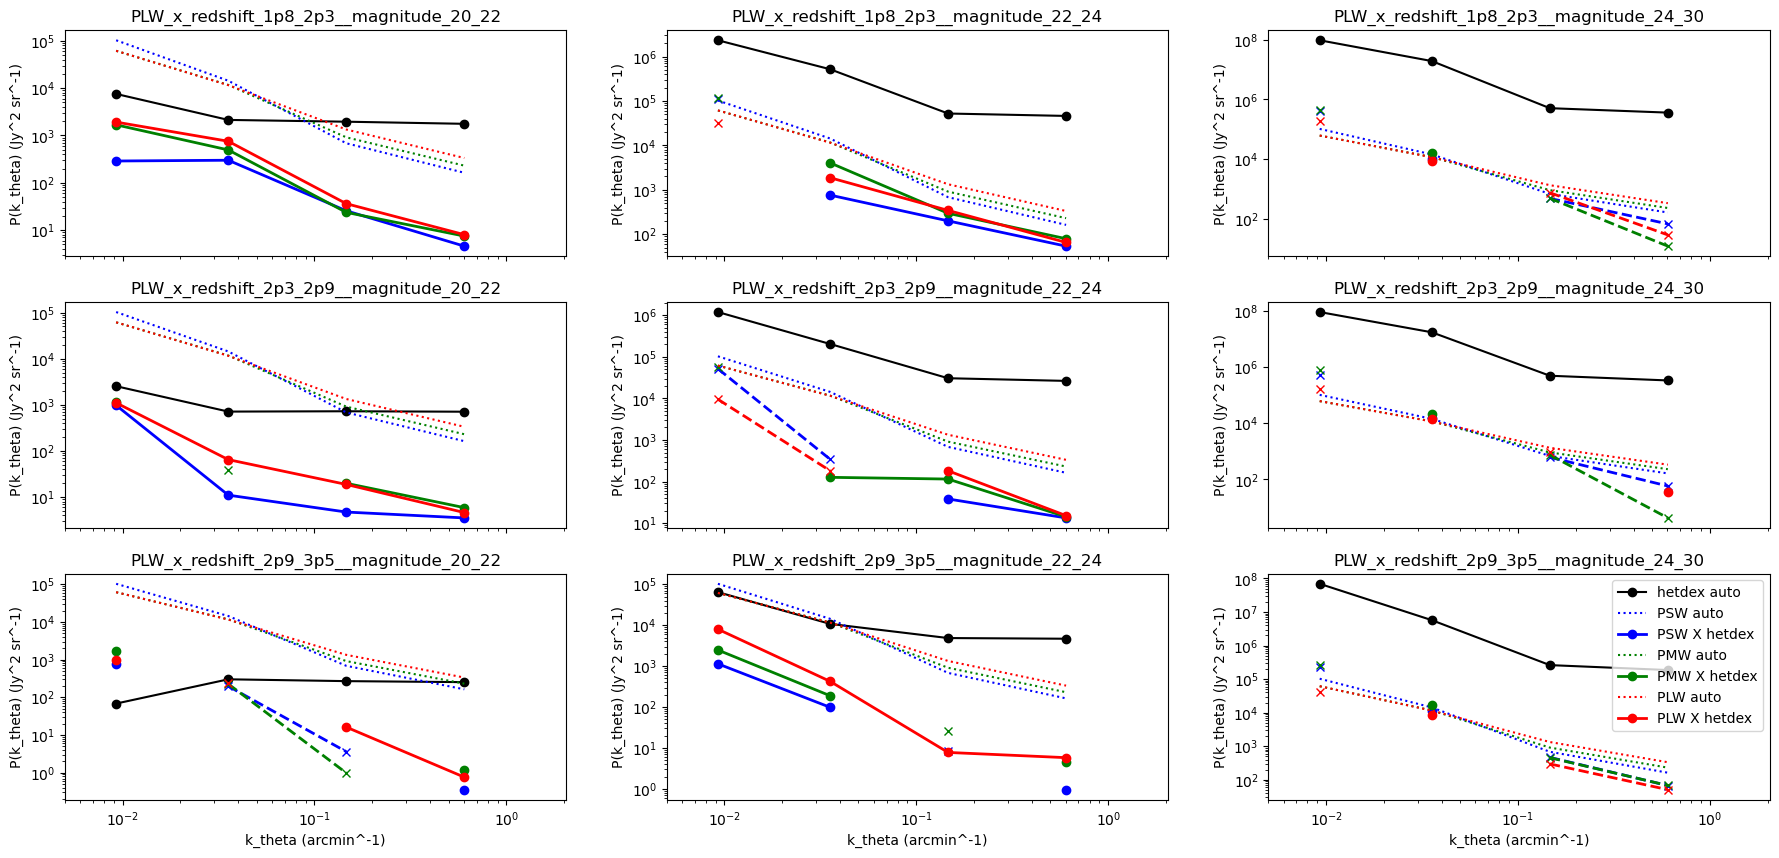

In [15]:
xs=3
ys=3
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
fig, axs = plt.subplots(xs, ys, figsize=(22, 10))
color=['b','g','r']
for i, hetdex_map_bin in enumerate(map_bins):
    ii = i//xs
    iii = np.mod(i,ys)
    
    for iwv, wv1 in enumerate(wvs):
        xcorr_label = '_x_'.join([wv1,hetdex_map_bin])
        
        pk_hers = pk_dict[wv1]['pk_hers'] 
        pk_hetdex = pk_dict[wv1][xcorr_label]['pk_hetdex'] 
        pk_hers_x_hetdex = pk_dict[wv1][xcorr_label]['pk_hers_x_hetdex'] 
        hers_mkk = mkk_dict[wv1]['hers_mkk']
        hetdex_mkk = mkk_dict[wv1][xcorr_label]['hetdex_mkk']
        hers_x_hetdex_mkk = mkk_dict[wv1][xcorr_label]['hers_x_hetdex_mkk']
        
        if not iwv:
            axs[ii,iii].plot(k_theta, np.matmul(pk_hetdex, hetdex_mkk), '-o', c='k', label='hetdex auto')
        axs[ii,iii].plot(k_theta, np.matmul(pk_hers, hers_mkk), ':', c=color[iwv], label='{} auto'.format(wv1))
        y_Hxh = np.sqrt(np.matmul(pk_hers_x_hetdex, hers_x_hetdex_mkk))**2
        y_Hxh_n = np.sqrt(-np.matmul(pk_hers_x_hetdex, hers_x_hetdex_mkk))**2
        axs[ii,iii].plot(k_theta, y_Hxh,'-o', lw=2, c=color[iwv], label='{} X hetdex'.format(wv1));
        axs[ii,iii].plot(k_theta, y_Hxh_n,'--x', lw=2, c=color[iwv]);

        #axs[ii,iii].set_ylim([1e2,4e5])
        axs[ii,iii].set_xlim([0.005,2.05])
        axs[ii,iii].set_xscale('log')
        axs[ii,iii].set_yscale('log')
        axs[ii,iii].set_title(xcorr_label)
        axs[ii,iii].set_ylabel('P(k_theta) (Jy^2 sr^-1)')
        
        if ii < ys-1:
            axs[ii,iii].set_xticklabels([])
        else:
            axs[ii,iii].set_xlabel('k_theta (arcmin^-1)')
            
plt.legend(loc='upper right');            

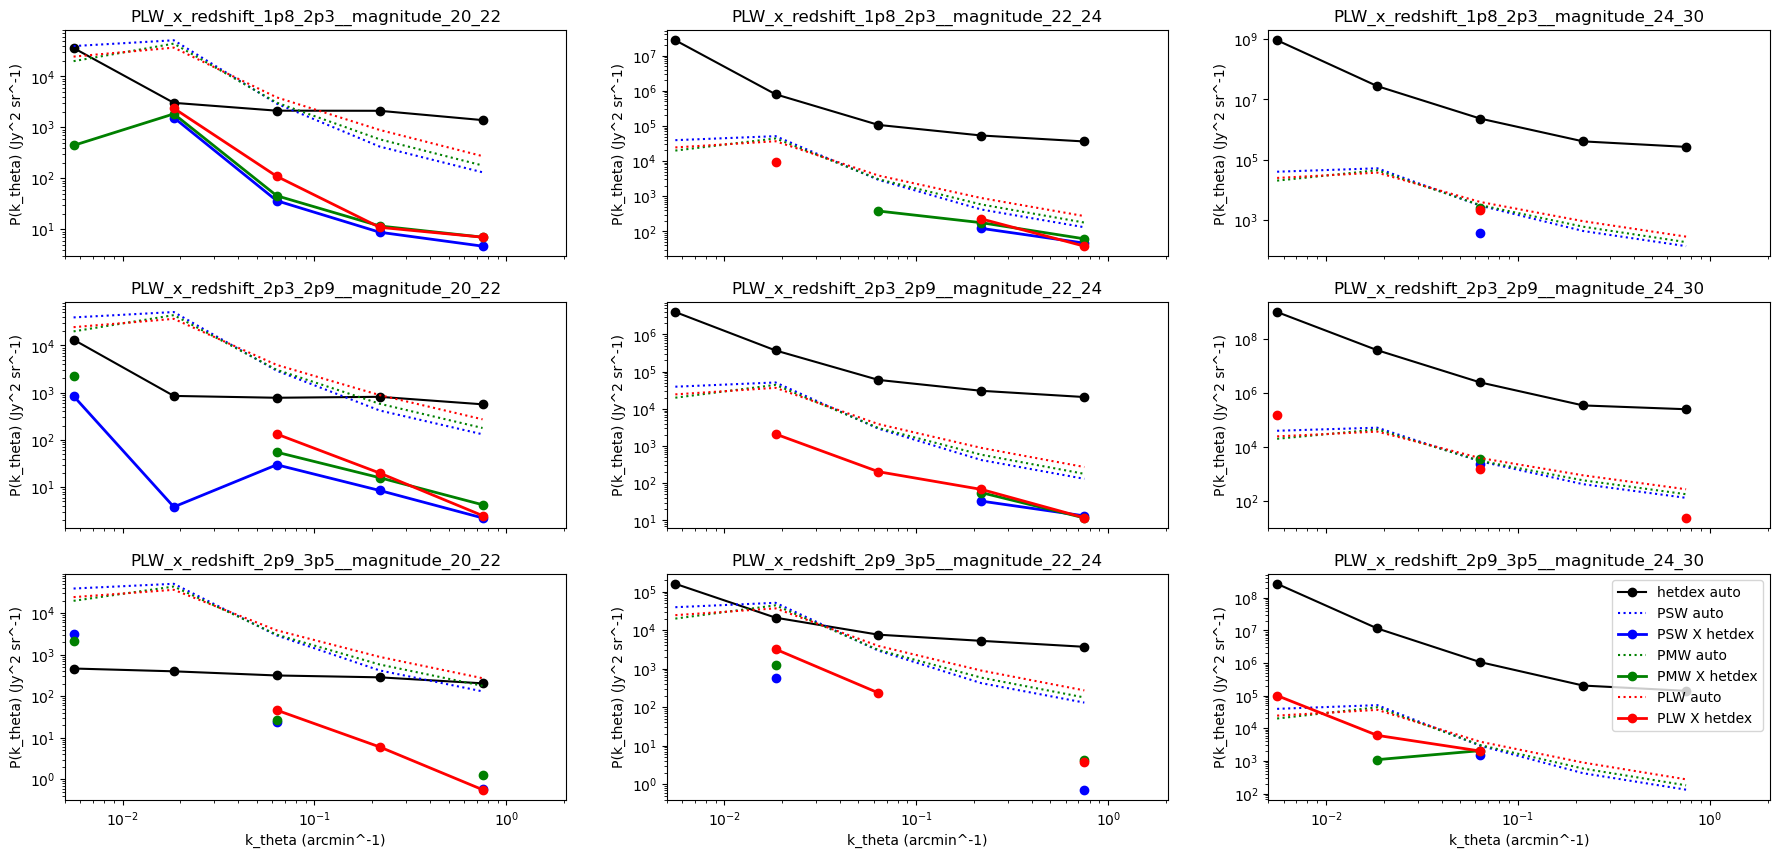

In [34]:
xs=3
ys=3
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
fig, axs = plt.subplots(xs, ys, figsize=(22, 10))
color=['b','g','r']
for i, hetdex_map_bin in enumerate(map_bins):
    ii = i//xs
    iii = np.mod(i,ys)
    
    for iwv, wv1 in enumerate(wvs):
        xcorr_label = '_x_'.join([wv1,hetdex_map_bin])
        
        pk_hers = pk_dict[wv1]['pk_hers'] 
        pk_hetdex = pk_dict[wv1][xcorr_label]['pk_hetdex'] 
        pk_hers_x_hetdex = pk_dict[wv1][xcorr_label]['pk_hers_x_hetdex'] 
        hers_mkk = mkk_dict[wv1]['hers_mkk']
        hetdex_mkk = mkk_dict[wv1][xcorr_label]['hetdex_mkk']
        hers_x_hetdex_mkk = mkk_dict[wv1][xcorr_label]['hers_x_hetdex_mkk']
        
        if not iwv:
            axs[ii,iii].plot(k_theta, np.matmul(pk_hetdex, hetdex_mkk), '-o', c='k', label='hetdex auto')
        axs[ii,iii].plot(k_theta, np.matmul(pk_hers, hers_mkk), ':', c=color[iwv], label='{} auto'.format(wv1))
        y_Hxh = np.sqrt(np.matmul(pk_hers_x_hetdex, hers_x_hetdex_mkk))**2
        axs[ii,iii].plot(k_theta, y_Hxh,'-o', lw=2, c=color[iwv], label='{} X hetdex'.format(wv1));

        #axs[ii,iii].set_ylim([1e2,4e5])
        axs[ii,iii].set_xlim([0.005,2.05])
        axs[ii,iii].set_xscale('log')
        axs[ii,iii].set_yscale('log')
        axs[ii,iii].set_title(xcorr_label)
        axs[ii,iii].set_ylabel('P(k_theta) (Jy^2 sr^-1)')
        
        if ii < ys-1:
            axs[ii,iii].set_xticklabels([])
        else:
            axs[ii,iii].set_xlabel('k_theta (arcmin^-1)')
            
plt.legend(loc='upper right');            

In [20]:
#hetdex_mask_path = os.path.join(path_hetdex_layers,'hetdex_footprint_mask',hetdex_masks[name]+'.fits')
hetdex_mask_path = os.path.join(path_hetdex_maps,'hetdex_footprint_mask','hetdex_mask__fwhm_35p2'+'.fits')
hetdex_all, hd_hetdex = fits.getdata(hetdex_mask_path, 0, header=True)
ind_zero = hetdex_all == 0
hetdex_mask = np.ones_like(hetdex_all)
hetdex_mask[ind_zero] = 0

(1425, 6891)


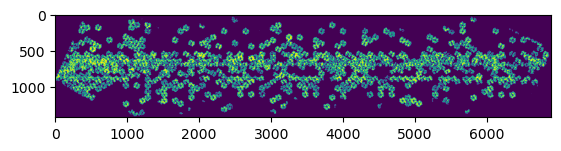

In [21]:
plt.imshow(hetdex_mask);
print(np.shape(hetdex_mask))

# Get K-map (i.e., rings)

In [57]:
try:
    pix_arcsec=hd_hers['CD2_2']*3600
except:
    pix_arcsec=hd_hers['CDELT2']*3600
shape_psw=np.shape(hers)
#dist_psw=dist_idl(shape_psw[0],shape_psw[1])
dist_psw=get_k_from_map(hers,pix_arcsec)

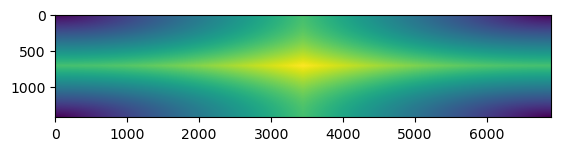

In [58]:
plt.imshow(dist_psw);

# Test recovery of input power spetrum

In [32]:
tst_ell, tst_pk_nomask = get_mc_mkk(hers_mask, hetdex_mask, deltal=deltal, width=width, nomask=True)

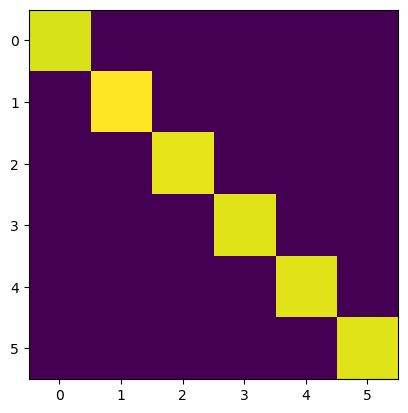

In [33]:
plt.imshow(tst_pk_nomask);

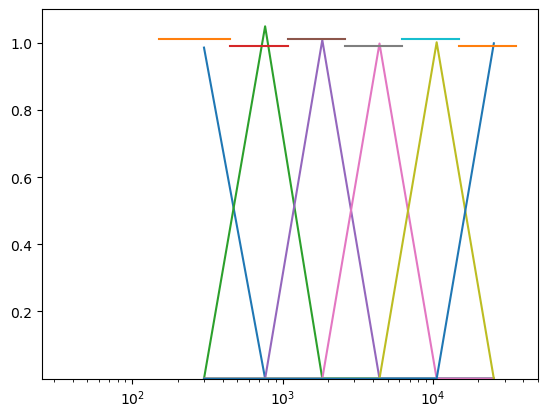

In [34]:
fudge_factor = 2.0
ell_out = (tst_ell[:-1]+tst_ell[1:])/2
for i in range(len(ell_out)):
    plt.plot(ell_out, fudge_factor*tst_pk_nomask[i]);
    yh = 1+0.01*(-1)**i
    plt.plot([tst_ell[i],tst_ell[i+1]],[yh,yh])
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlim([25,50000])    
    plt.ylim([1e-8,1.1])

# Get mask X mask MKK

In [59]:
tst_ell, hers_x_hetdex_mask_pk = get_mc_mkk(hers_mask, hetdex_mask, deltal=deltal, width=width)

In [60]:
hers_x_hetdex_mkk=np.linalg.inv(hers_x_hetdex_mask_pk)

In [61]:
tst_ell, hetdex_mask_pk = get_mc_mkk(hetdex_mask, hetdex_mask, deltal=deltal, width=width)

In [62]:
hetdex_mkk=np.linalg.inv(hetdex_mask_pk)

In [63]:
tst_ell, hers_mask_pk = get_mc_mkk(hers_mask, hers_mask, deltal=deltal, width=width)

In [64]:
hers_mkk=np.linalg.inv(hers_mask_pk)

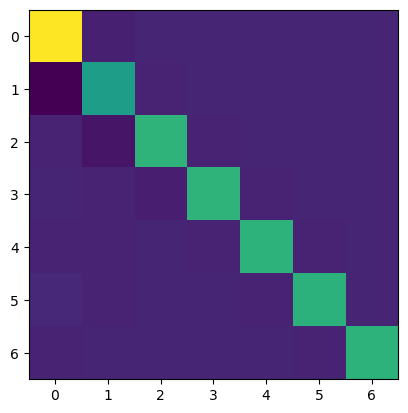

In [71]:
plt.imshow(hers_x_hetdex_mkk);

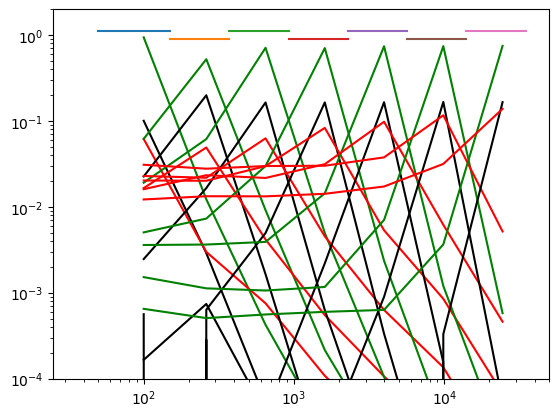

In [66]:
fudge_factor=2.0
ell_out = (tst_ell[:-1]+tst_ell[1:])/2
for i in range(len(ell_out)):
    plt.plot(ell_out, fudge_factor*hers_x_hetdex_mask_pk[i],'k');
    plt.plot(ell_out, fudge_factor*hers_mask_pk[i],'g');
    plt.plot(ell_out, fudge_factor*hetdex_mask_pk[i],'r');
    yh = 1+0.1*(-1)**i
    plt.plot([tst_ell[i],tst_ell[i+1]],[yh,yh])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([25,50000])    
    plt.ylim([1e-4,2])

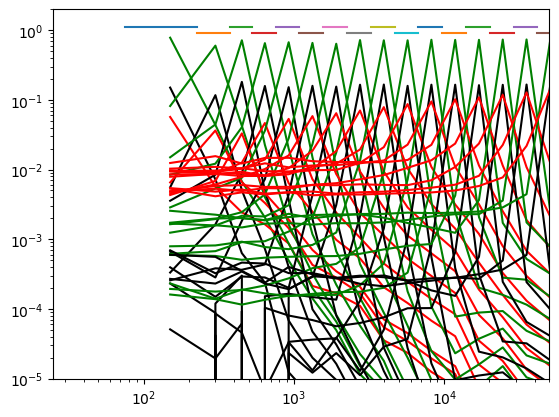

In [269]:
fudge_factor=2.0
ell_out = (tst_ell[:-1]+tst_ell[1:])/2
for i in range(len(ell_out)):
    plt.plot(ell_out, fudge_factor*hers_x_hetdex_mask_pk[i],'k');
    plt.plot(ell_out, fudge_factor*hers_mask_pk[i],'g');
    plt.plot(ell_out, fudge_factor*hetdex_mask_pk[i],'r');
    yh = 1+0.1*(-1)**i
    plt.plot([tst_ell[i],tst_ell[i+1]],[yh,yh])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([25,50000])    
    plt.ylim([1e-5,2])

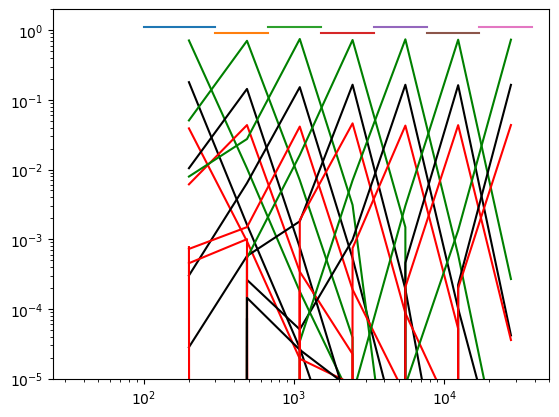

In [55]:
fudge_factor=2.0
ell_out = (tst_ell[:-1]+tst_ell[1:])/2
for i in range(len(ell_out)):
    plt.plot(ell_out, fudge_factor*hers_x_hetdex_mask_pk[i],'k');
    plt.plot(ell_out, fudge_factor*hers_mask_pk[i],'g');
    plt.plot(ell_out, fudge_factor*hetdex_mask_pk[i],'r');
    yh = 1+0.1*(-1)**i
    plt.plot([tst_ell[i],tst_ell[i+1]],[yh,yh])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([25,50000])    
    plt.ylim([1e-5,2])

# Loop over HETDEX bins

In [67]:
try:
    pix_arcsec=hd_hers['CD2_2']*3600
except:
    pix_arcsec=hd_hers['CDELT2']*3600
fft_hers = get_twod_fft(hers, pix_arcsec=pix_arcsec)

In [68]:
fft_dict = {'PSW':{}}
for wv, ffts in fft_dict.items(): 
    for hetdex_map_bin in map_bins:
        ffts[hetdex_map_bin] = {}
        hetdex_bin_path = os.path.join(path_hetdex_layers,hetdex_map_bin+map_key_dict[wv]+'.fits')
        hetdex, hd_hetdex = fits.getdata(hetdex_bin_path, 0, header=True)
        ffts[hetdex_map_bin]['fft_hers_x_hetdex'] = get_twod_fft(hers, map_two=hetdex, pix_arcsec=pix_arcsec)
        ffts[hetdex_map_bin]['fft_hetdex'] = get_twod_fft(hetdex, pix_arcsec=pix_arcsec)
        #pdb.set_trace()

In [69]:
ell_bins = get_ell_bins(hers, pix_arcsec, deltal=deltal, width=width)
pk_hers = bin_in_rings(fft_hers, ell_bins, k_psw)
pk_dict = {'PSW':{}}
for wv, ffts in fft_dict.items():
    for fft_bin in ffts:
        pk_dict[wv][fft_bin] = {}
        pk_dict[wv][fft_bin]['pk_hers_x_hetdex'] = bin_in_rings(ffts[fft_bin]['fft_hers_x_hetdex'], ell_bins, k_psw)
        pk_dict[wv][fft_bin]['pk_hetdex'] = bin_in_rings(ffts[fft_bin]['fft_hetdex'], ell_bins, k_psw)
        #pdb.set_trace()

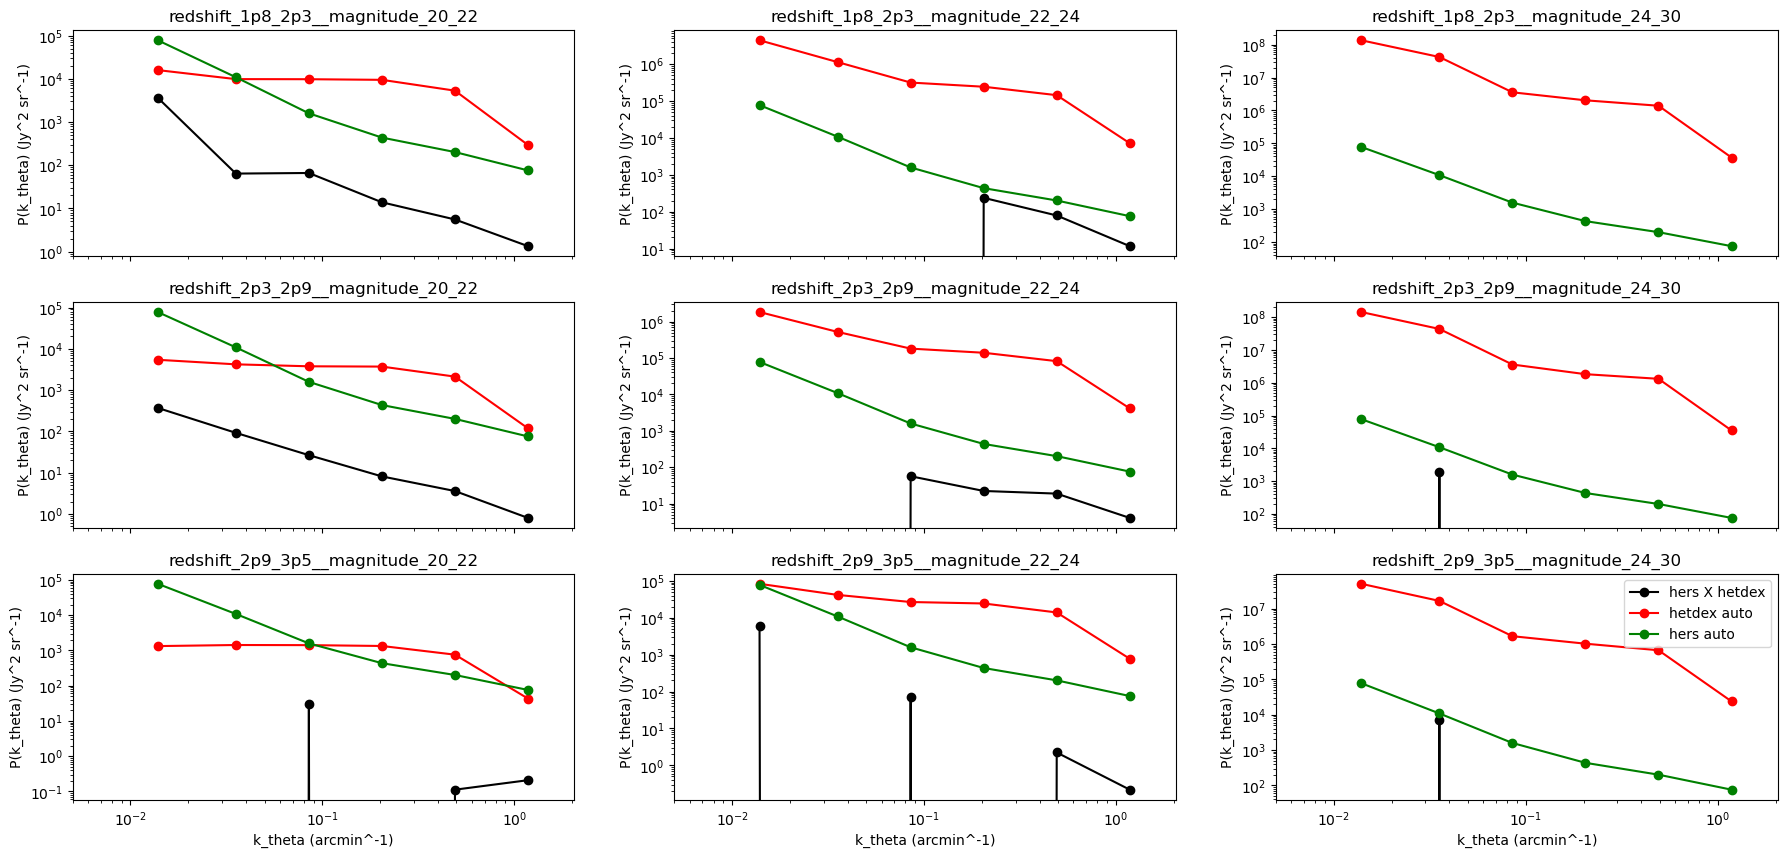

In [41]:
xs=3
ys=3
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
fig, axs = plt.subplots(xs, ys, figsize=(22, 10))
for wv, pks in pk_dict.items():
    for i, pk_bin in enumerate(pks):
        ii = i//xs
        iii = np.mod(i,ys)
        axs[ii,iii].plot(k_theta, np.matmul(pks[pk_bin]['pk_hers_x_hetdex'], hers_x_hetdex_mkk),'-o', c='k', label='hers X hetdex');
        axs[ii,iii].plot(k_theta, np.matmul(pks[pk_bin]['pk_hetdex'], hetdex_mkk), '-o', c='r', label='hetdex auto')
        #axs[ii,iii].scatter(k_theta, np.matmul(pk_hers, hers_mkk), c='g')
        axs[ii,iii].plot(k_theta, np.matmul(pk_hers, hers_mkk), '-o', c='g', label='hers auto')
        #axs[ii,iii].set_ylim([1e-1,1e8])
        #axs[ii,iii].set_ylim([1e2,4e5])
        axs[ii,iii].set_xlim([0.005,2.05])
        axs[ii,iii].set_xscale('log')
        axs[ii,iii].set_yscale('log')
        axs[ii,iii].set_title(pk_bin)
        axs[ii,iii].set_ylabel('P(k_theta) (Jy^2 sr^-1)')
        
        if ii < ys-1:
            axs[ii,iii].set_xticklabels([])
        else:
            axs[ii,iii].set_xlabel('k_theta (arcmin^-1)')
            
plt.legend(loc='upper right');            

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


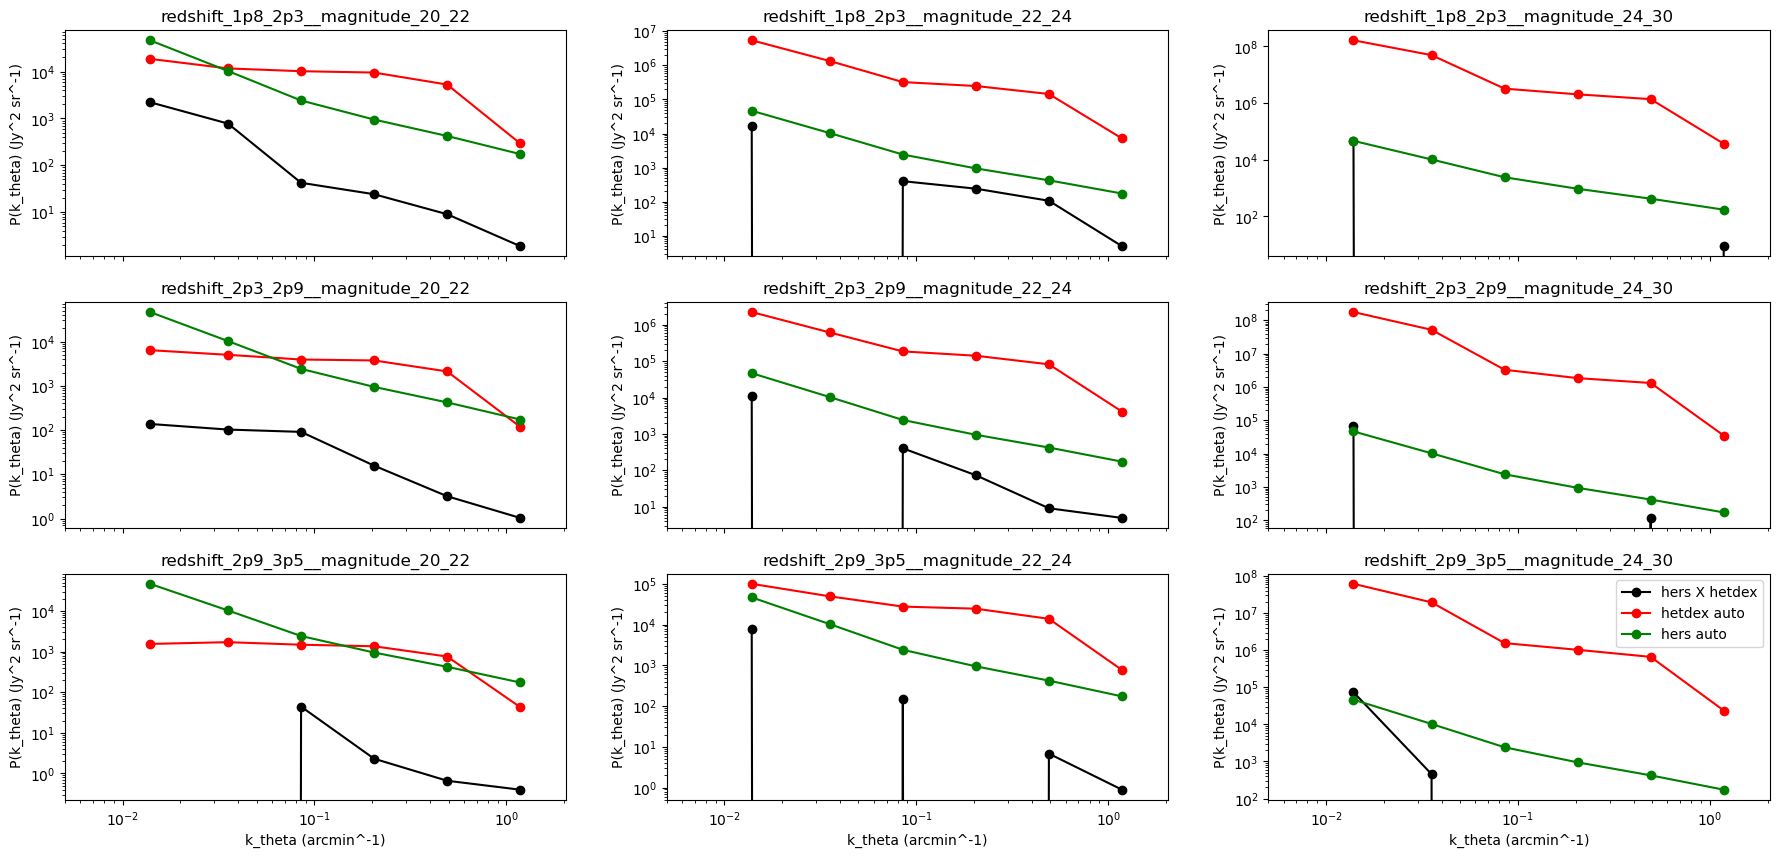

In [45]:
xs=3
ys=3
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
fig, axs = plt.subplots(xs, ys, figsize=(22, 10))
for wv, pks in pk_dict.items():
    for i, pk_bin in enumerate(pks):
        ii = i//xs
        iii = np.mod(i,ys)
        axs[ii,iii].plot(k_theta, np.matmul(pks[pk_bin]['pk_hers_x_hetdex'], hers_x_hetdex_mkk),'-o', c='k', label='hers X hetdex');
        axs[ii,iii].plot(k_theta, np.matmul(pks[pk_bin]['pk_hetdex'], hetdex_mkk), '-o', c='r', label='hetdex auto')
        #axs[ii,iii].scatter(k_theta, np.matmul(pk_hers, hers_mkk), c='g')
        axs[ii,iii].plot(k_theta, np.matmul(pk_hers, hers_mkk), '-o', c='g', label='hers auto')
        #axs[ii,iii].set_ylim([1e-1,1e8])
        #axs[ii,iii].set_ylim([1e2,4e5])
        axs[ii,iii].set_xlim([0.005,2.05])
        axs[ii,iii].set_xscale('log')
        axs[ii,iii].set_yscale('log')
        axs[ii,iii].set_title(pk_bin)
        axs[ii,iii].set_ylabel('P(k_theta) (Jy^2 sr^-1)')
        
        if ii < ys-1:
            axs[ii,iii].set_xticklabels([])
        else:
            axs[ii,iii].set_xlabel('k_theta (arcmin^-1)')
            
plt.legend(loc='upper right');            

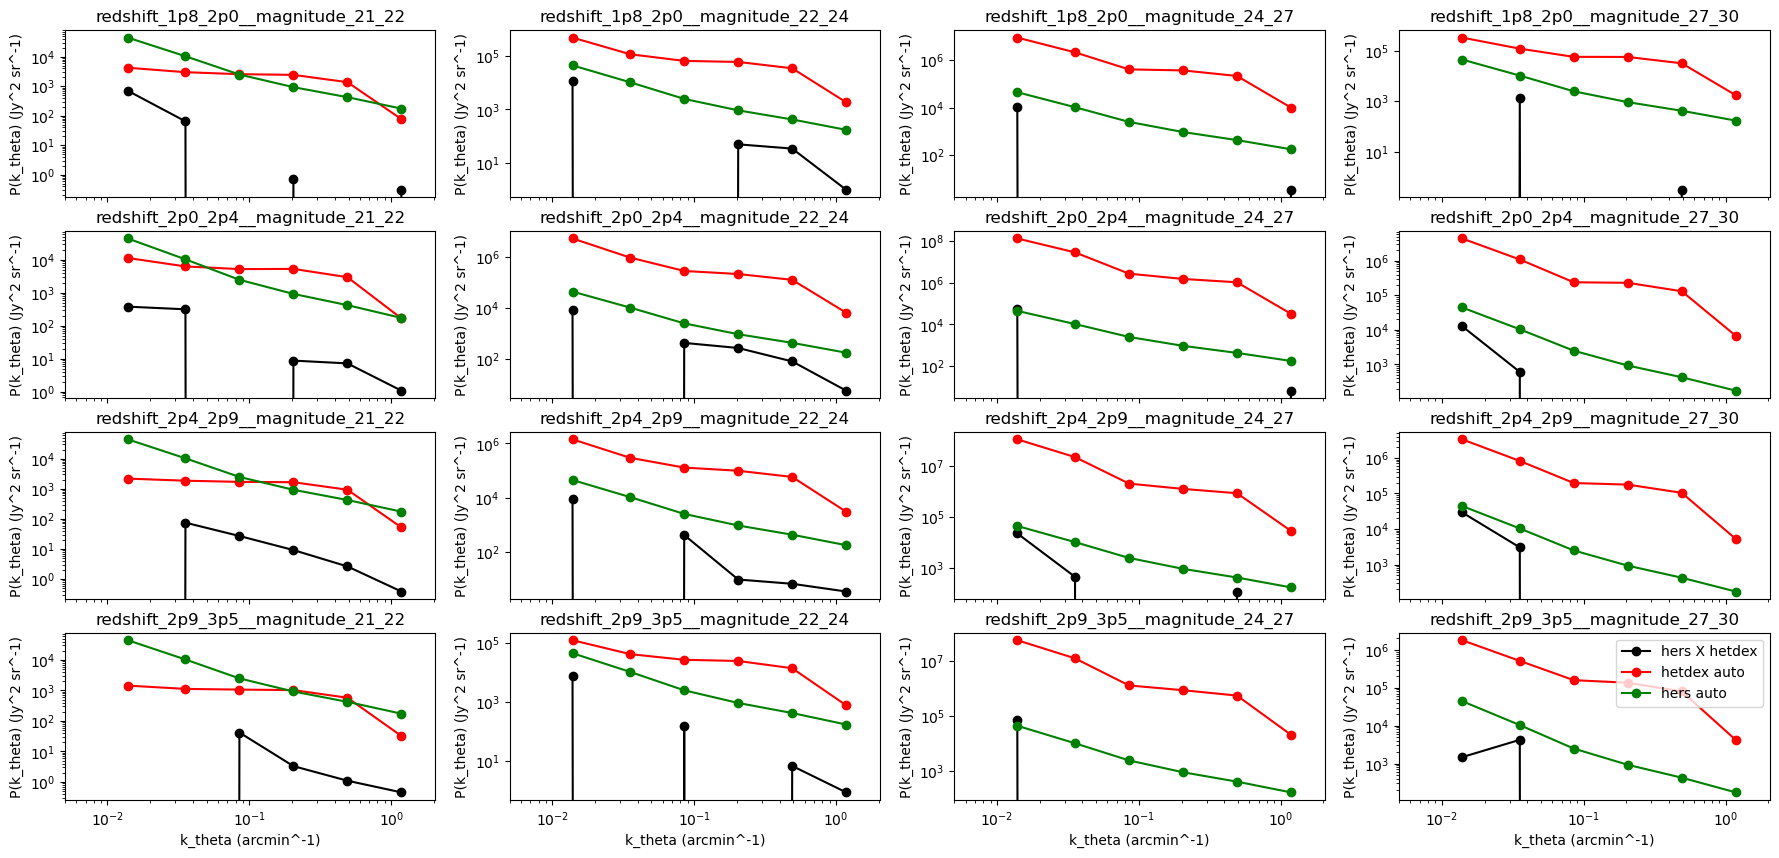

In [90]:
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
fig, axs = plt.subplots(4, 4, figsize=(22, 10))
for wv, pks in pk_dict.items():
    for i, pk_bin in enumerate(pks):
        ii = i//4
        iii = np.mod(i,4)
        axs[ii,iii].plot(k_theta, np.matmul(pks[pk_bin]['pk_hers_x_hetdex'], hers_x_hetdex_mkk),'-o', c='k', label='hers X hetdex');
        axs[ii,iii].plot(k_theta, np.matmul(pks[pk_bin]['pk_hetdex'], hetdex_mkk), '-o', c='r', label='hetdex auto')
        #axs[ii,iii].scatter(k_theta, np.matmul(pk_hers, hers_mkk), c='g')
        axs[ii,iii].plot(k_theta, np.matmul(pk_hers, hers_mkk), '-o', c='g', label='hers auto')
        #axs[ii,iii].set_ylim([1e-1,1e8])
        #axs[ii,iii].set_ylim([1e2,4e5])
        axs[ii,iii].set_xlim([0.005,2.05])
        axs[ii,iii].set_xscale('log')
        axs[ii,iii].set_yscale('log')
        axs[ii,iii].set_title(pk_bin)
        axs[ii,iii].set_ylabel('P(k_theta) (Jy^2 sr^-1)')
        
        if ii < 3:
            axs[ii,iii].set_xticklabels([])
        else:
            axs[ii,iii].set_xlabel('k_theta (arcmin^-1)')
            
plt.legend(loc='upper right');            

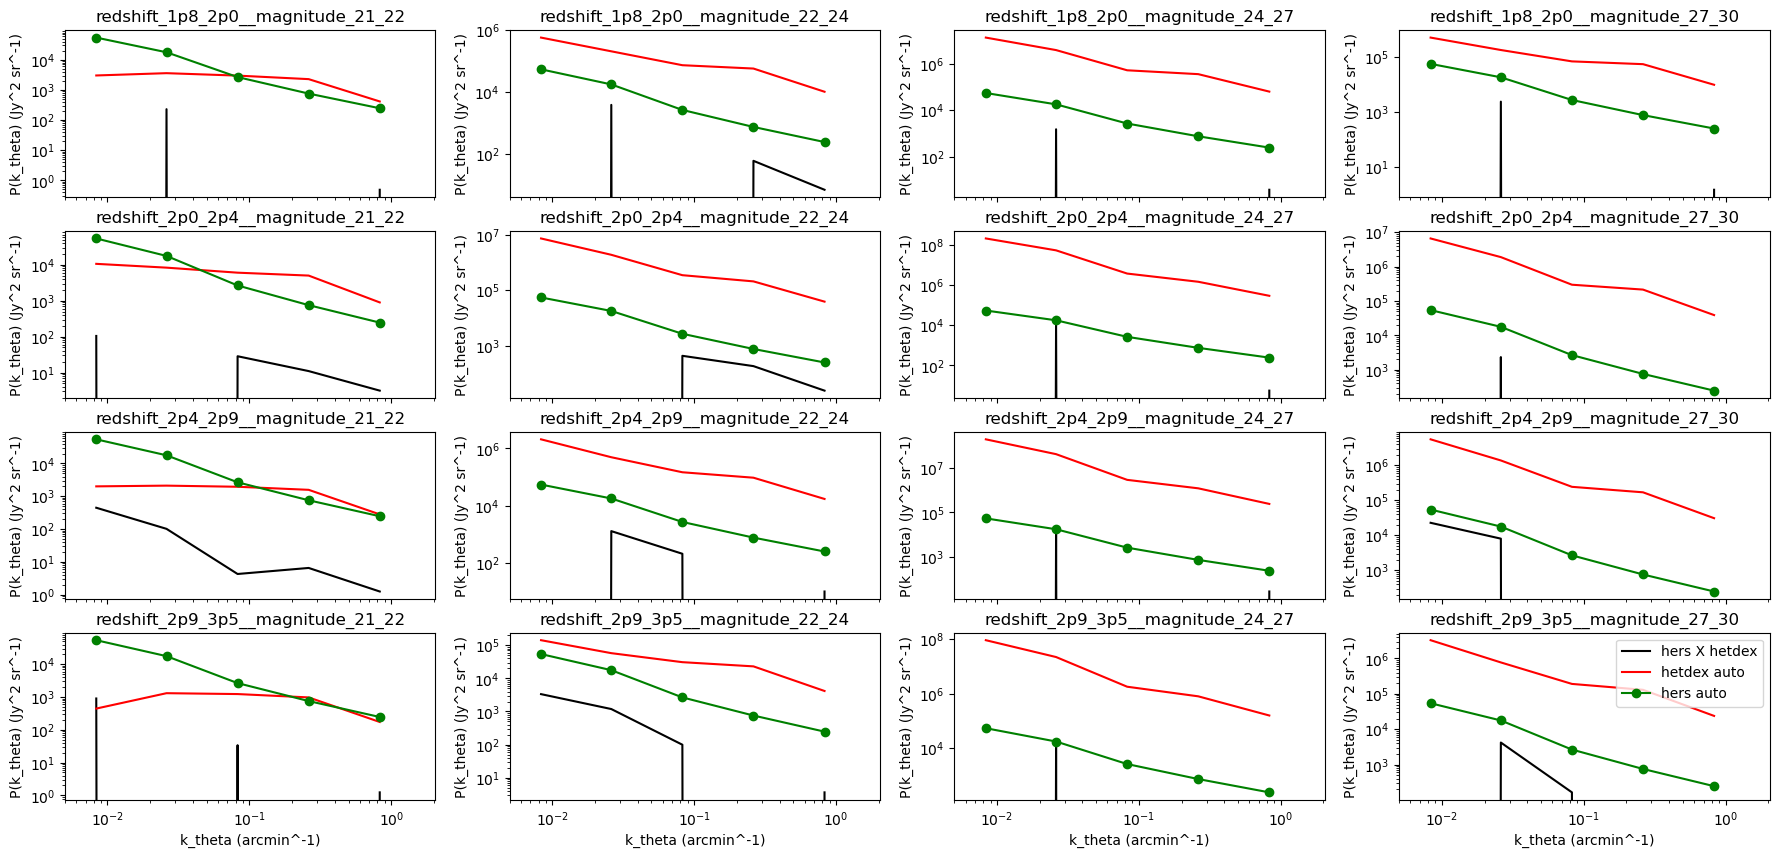

In [95]:
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
fig, axs = plt.subplots(4, 4, figsize=(22, 10))
for wv, pks in pk_dict.items():
    for i, pk_bin in enumerate(pks):
        ii = i//4
        iii = np.mod(i,4)
        axs[ii,iii].plot(k_theta, np.matmul(pks[pk_bin]['pk_hers_x_hetdex'], hers_x_hetdex_mkk), c='k', label='hers X hetdex');
        axs[ii,iii].plot(k_theta, np.matmul(pks[pk_bin]['pk_hetdex'], hetdex_mkk), c='r', label='hetdex auto')
        #axs[ii,iii].scatter(k_theta, np.matmul(pk_hers, hers_mkk), c='g')
        axs[ii,iii].plot(k_theta, np.matmul(pk_hers, hers_mkk), '-o', c='g', label='hers auto')
        #axs[ii,iii].set_ylim([1e-1,1e8])
        #axs[ii,iii].set_ylim([1e2,4e5])
        axs[ii,iii].set_xlim([0.005,2.05])
        axs[ii,iii].set_xscale('log')
        axs[ii,iii].set_yscale('log')
        axs[ii,iii].set_title(pk_bin)
        axs[ii,iii].set_ylabel('P(k_theta) (Jy^2 sr^-1)')
        
        if ii < 3:
            axs[ii,iii].set_xticklabels([])
        else:
            axs[ii,iii].set_xlabel('k_theta (arcmin^-1)')
            
plt.legend(loc='upper right');            

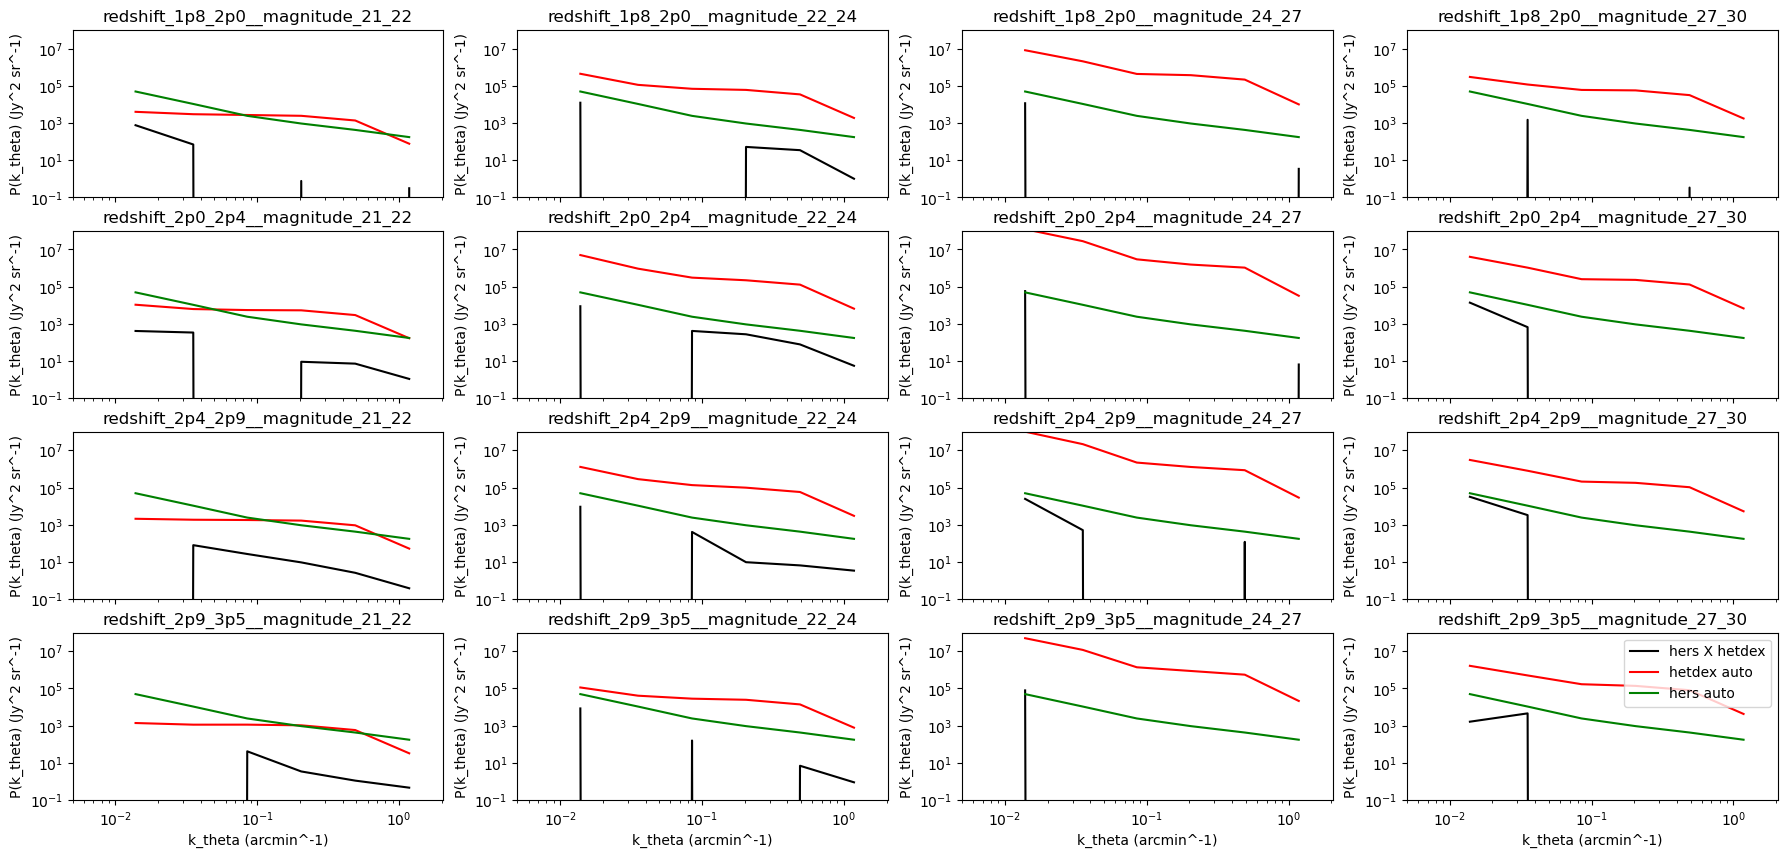

In [59]:
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
fig, axs = plt.subplots(4, 4, figsize=(22, 10))
for wv, pks in pk_dict.items():
    for i, pk_bin in enumerate(pks):
        ii = i//4
        iii = np.mod(i,4)
        axs[ii,iii].plot(k_theta, np.matmul(pks[pk_bin]['pk_hers_x_hetdex'], hers_x_hetdex_mkk), c='k', label='hers X hetdex');
        axs[ii,iii].plot(k_theta, np.matmul(pks[pk_bin]['pk_hetdex'], hetdex_mkk), c='r', label='hetdex auto')
        axs[ii,iii].plot(k_theta, np.matmul(pk_hers, hers_mkk), c='g', label='hers auto')
        axs[ii,iii].set_ylim([1e-1,1e8])
        #axs[ii,iii].set_ylim([1e3,4e5])
        axs[ii,iii].set_xlim([0.005,2.05])
        axs[ii,iii].set_xscale('log')
        axs[ii,iii].set_yscale('log')
        axs[ii,iii].set_title(pk_bin)
        axs[ii,iii].set_ylabel('P(k_theta) (Jy^2 sr^-1)')
        
        if ii < 3:
            axs[ii,iii].set_xticklabels([])
        else:
            axs[ii,iii].set_xlabel('k_theta (arcmin^-1)')
            
plt.legend(loc='upper right');            

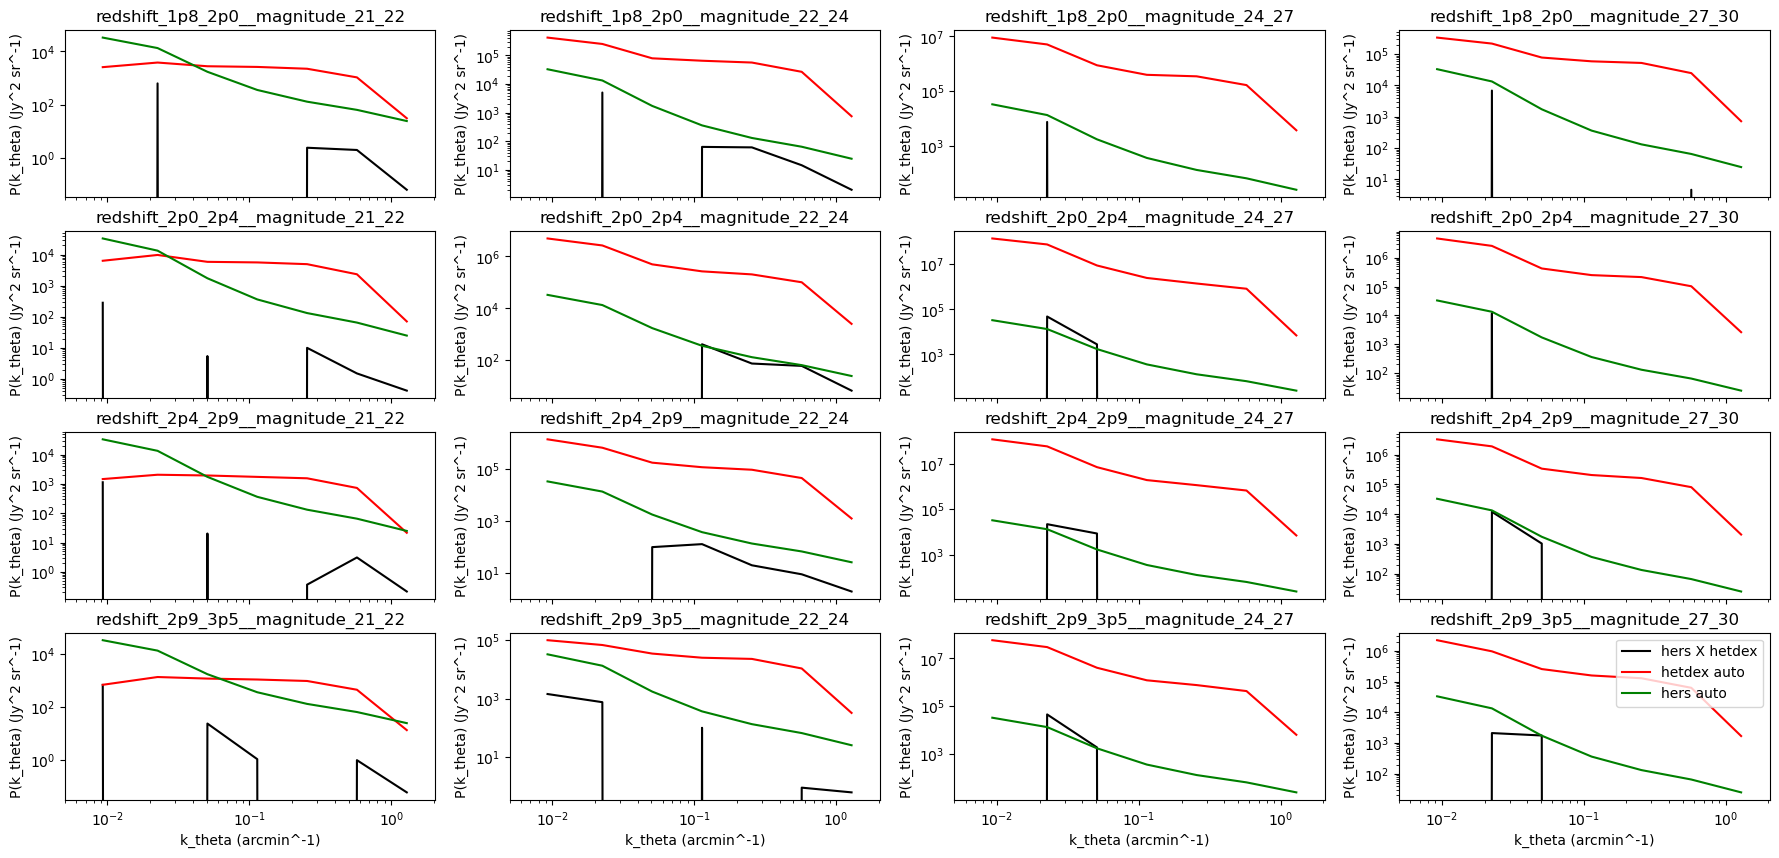

In [378]:
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
fig, axs = plt.subplots(4, 4, figsize=(22, 10))
for wv, pks in pk_dict.items():
    for i, pk_bin in enumerate(pks):
        ii = i//4
        iii = np.mod(i,4)
        axs[ii,iii].plot(k_theta, np.matmul(pks[pk_bin]['pk_hers_x_hetdex'], hers_x_hetdex_mkk), c='k', label='hers X hetdex');
        axs[ii,iii].plot(k_theta, np.matmul(pks[pk_bin]['pk_hetdex'], hetdex_mkk), c='r', label='hetdex auto')
        #axs[ii,iii].plot(k_theta, np.matmul(pk_hers, hers_mkk), c='g', label='hers auto')
        axs[ii,iii].plot(k_theta,  pk_hers, c='g', label='hers auto')
        #axs[ii,iii].set_ylim([1e-1,1e6])
        #axs[ii,iii].set_ylim([1e3,4e5])
        axs[ii,iii].set_xlim([0.005,2.05])
        axs[ii,iii].set_xscale('log')
        axs[ii,iii].set_yscale('log')
        axs[ii,iii].set_title(pk_bin)
        axs[ii,iii].set_ylabel('P(k_theta) (Jy^2 sr^-1)')
        
        if ii < 3:
            axs[ii,iii].set_xticklabels([])
        else:
            axs[ii,iii].set_xlabel('k_theta (arcmin^-1)')
            
#        print(ii, iii, pk_bin)

plt.legend(loc='upper right');            


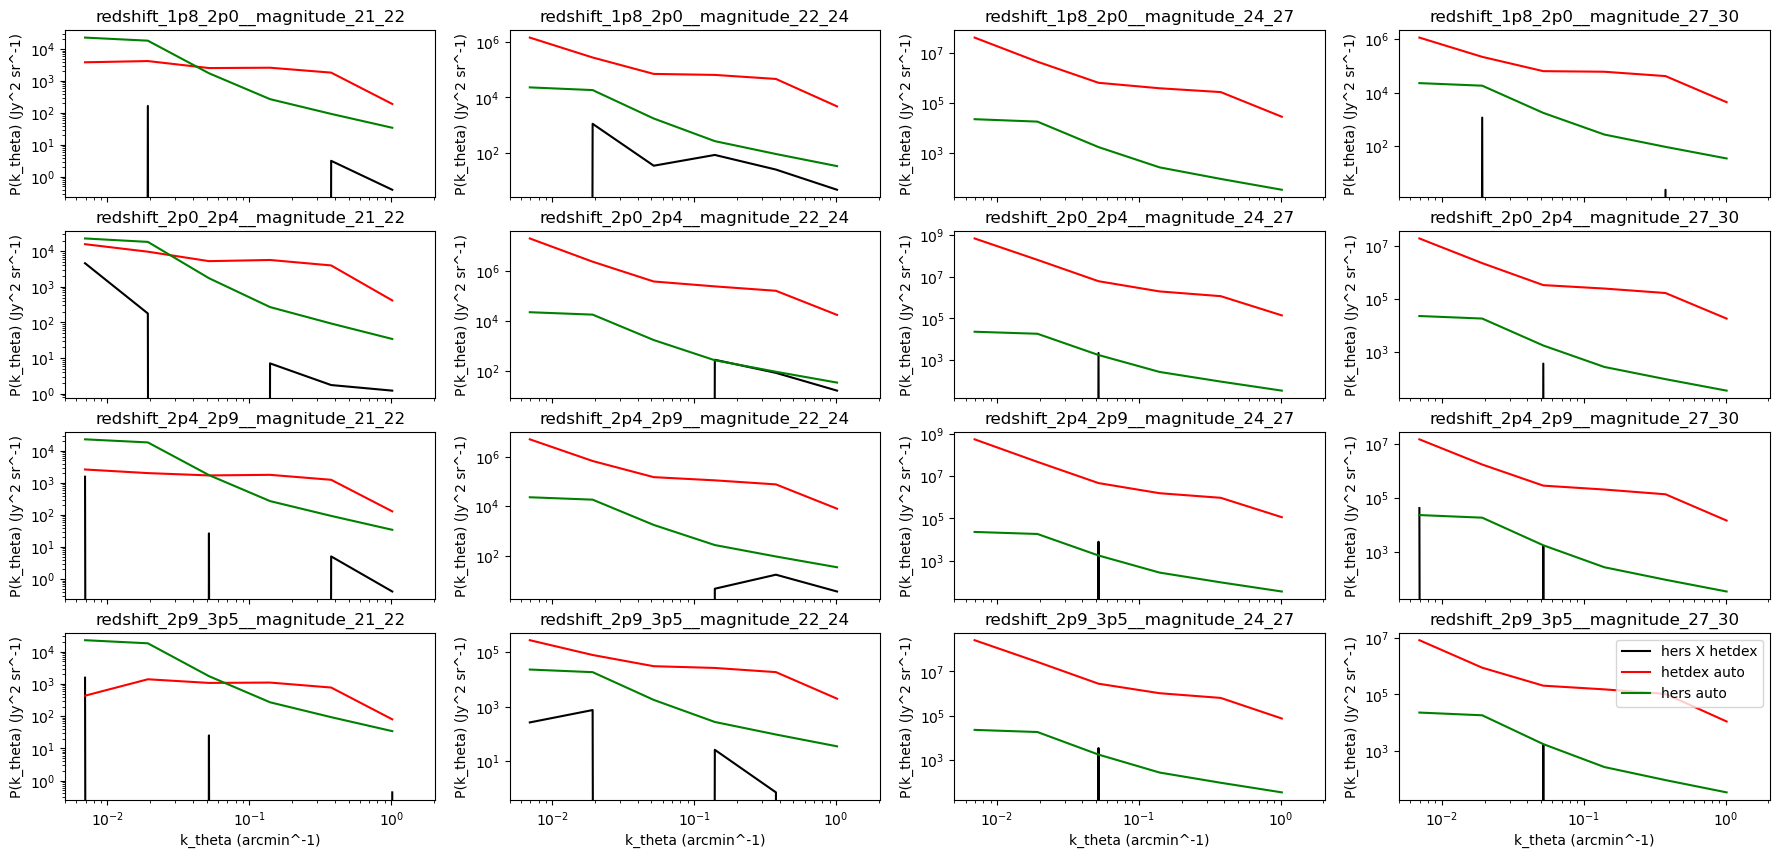

In [346]:
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
fig, axs = plt.subplots(4, 4, figsize=(22, 10))
for wv, pks in pk_dict.items():
    for i, pk_bin in enumerate(pks):
        ii = i//4
        iii = np.mod(i,4)
        axs[ii,iii].plot(k_theta, np.matmul(pks[pk_bin]['pk_hers_x_hetdex'], hers_x_hetdex_mkk), c='k', label='hers X hetdex');
        axs[ii,iii].plot(k_theta, np.matmul(pks[pk_bin]['pk_hetdex'], hetdex_mkk), c='r', label='hetdex auto')
        #axs[ii,iii].plot(k_theta, np.matmul(pk_hers, hers_mkk), c='g', label='hers auto')
        axs[ii,iii].plot(k_theta,  pk_hers, c='g', label='hers auto')
        #axs[ii,iii].set_ylim([1e-1,1e6])
        #axs[ii,iii].set_ylim([1e3,4e5])
        axs[ii,iii].set_xlim([0.005,2.05])
        axs[ii,iii].set_xscale('log')
        axs[ii,iii].set_yscale('log')
        axs[ii,iii].set_title(pk_bin)
        axs[ii,iii].set_ylabel('P(k_theta) (Jy^2 sr^-1)')
        
        if ii < 3:
            axs[ii,iii].set_xticklabels([])
        else:
            axs[ii,iii].set_xlabel('k_theta (arcmin^-1)')
            
#        print(ii, iii, pk_bin)

plt.legend(loc='upper right');            


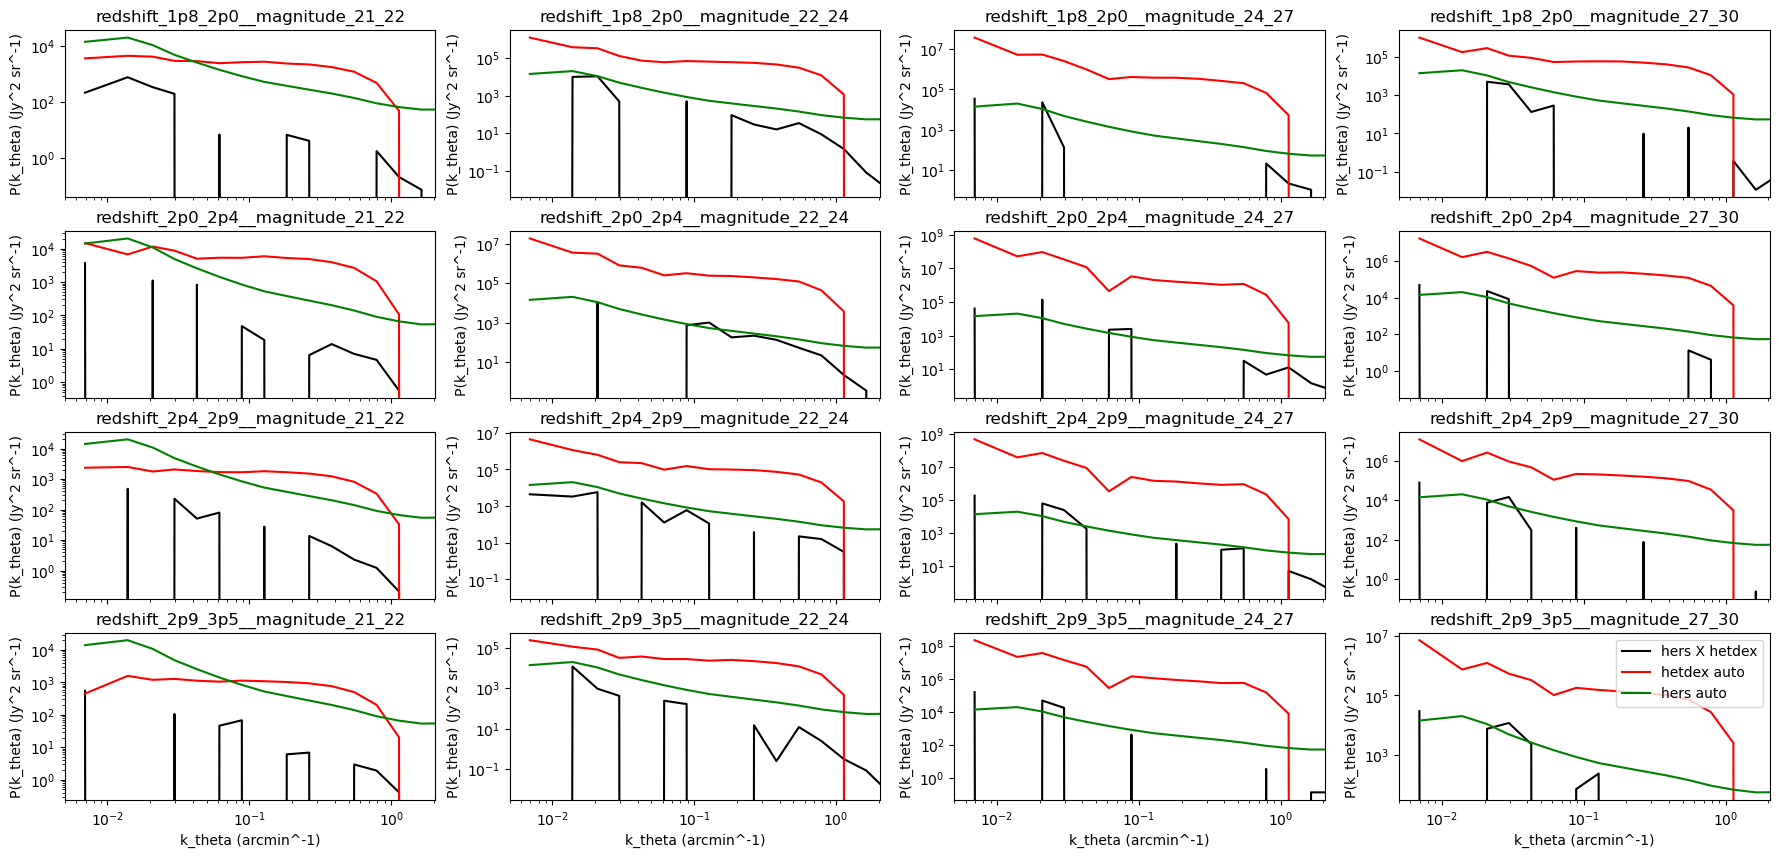

In [273]:
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
fig, axs = plt.subplots(4, 4, figsize=(22, 10))
for wv, pks in pk_dict.items():
    for i, pk_bin in enumerate(pks):
        ii = i//4
        iii = np.mod(i,4)
        axs[ii,iii].plot(k_theta, np.matmul(pks[pk_bin]['pk_hers_x_hetdex'], hers_x_hetdex_mkk), c='k', label='hers X hetdex');
        axs[ii,iii].plot(k_theta, np.matmul(pks[pk_bin]['pk_hetdex'], hetdex_mkk), c='r', label='hetdex auto')
        #axs[ii,iii].plot(k_theta, np.matmul(pk_hers, hers_mkk), c='g', label='hers auto')
        axs[ii,iii].plot(k_theta,  pk_hers, c='g', label='hers auto')
        #axs[ii,iii].set_ylim([1e-1,1e6])
        #axs[ii,iii].set_ylim([1e3,4e5])
        axs[ii,iii].set_xlim([0.005,2.05])
        axs[ii,iii].set_xscale('log')
        axs[ii,iii].set_yscale('log')
        axs[ii,iii].set_title(pk_bin)
        axs[ii,iii].set_ylabel('P(k_theta) (Jy^2 sr^-1)')
        
        if ii < 3:
            axs[ii,iii].set_xticklabels([])
        else:
            axs[ii,iii].set_xlabel('k_theta (arcmin^-1)')
            
#        print(ii, iii, pk_bin)

plt.legend(loc='upper right');            


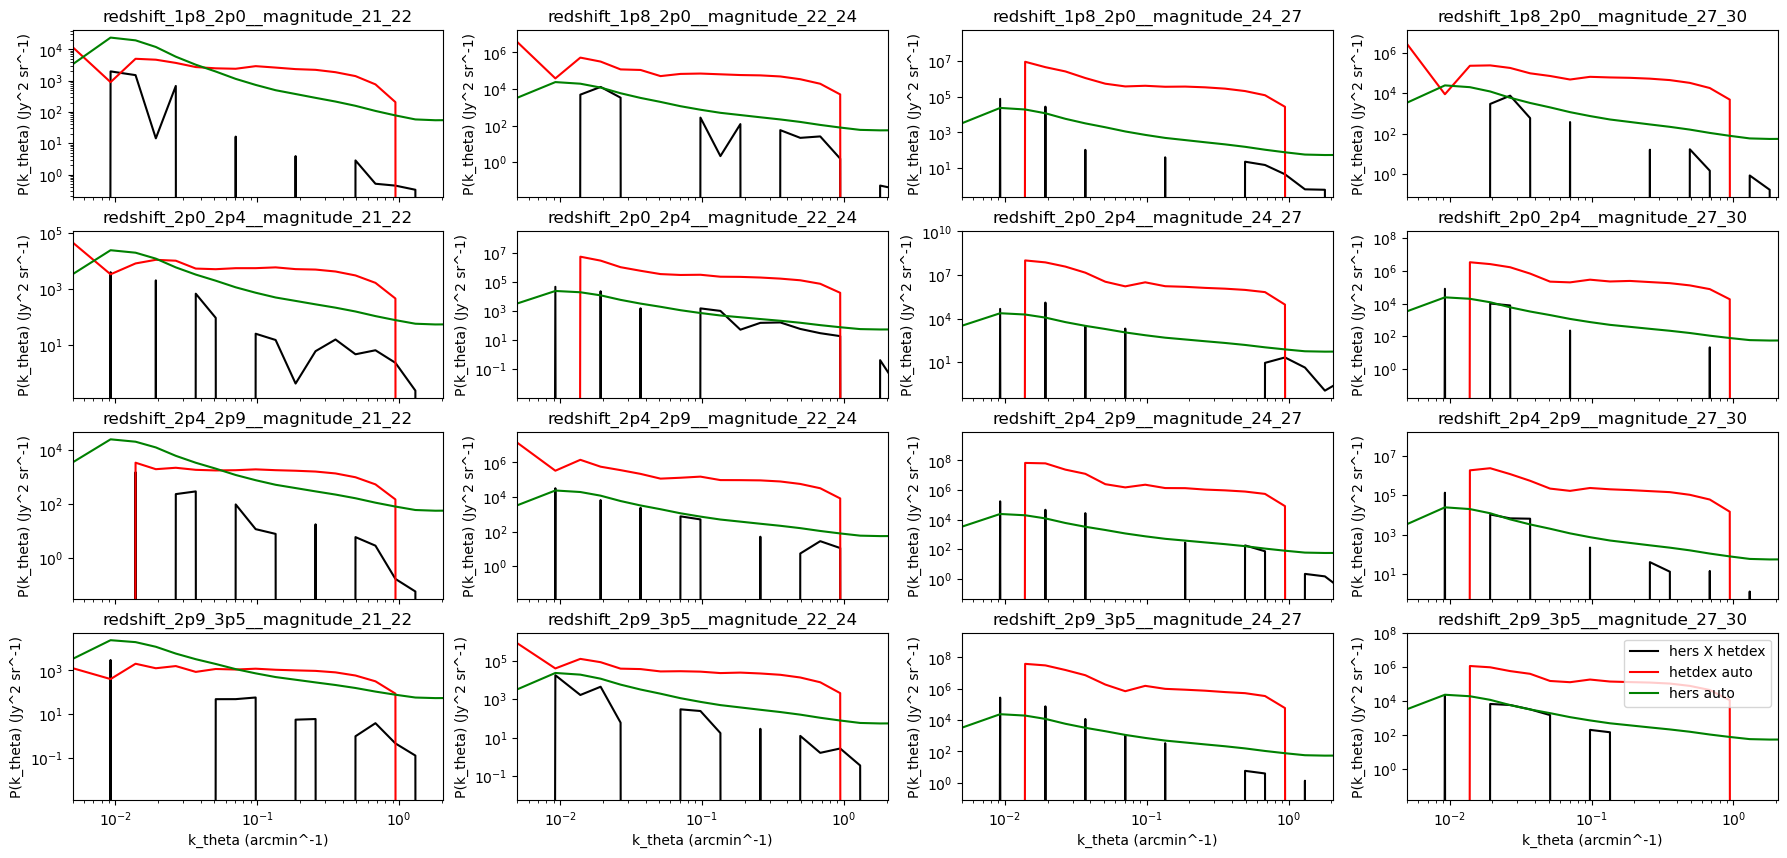

In [246]:
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
fig, axs = plt.subplots(4, 4, figsize=(22, 10))
for wv, pks in pk_dict.items():
    for i, pk_bin in enumerate(pks):
        ii = i//4
        iii = np.mod(i,4)
        axs[ii,iii].plot(k_theta, np.matmul(pks[pk_bin]['pk_hers_x_hetdex'], hers_x_hetdex_mkk), c='k', label='hers X hetdex');
        axs[ii,iii].plot(k_theta, np.matmul(pks[pk_bin]['pk_hetdex'], hetdex_mkk), c='r', label='hetdex auto')
        #axs[ii,iii].plot(k_theta, np.matmul(pk_hers, hers_mkk), c='g', label='hers auto')
        axs[ii,iii].plot(k_theta,  pk_hers, c='g', label='hers auto')
        #axs[ii,iii].set_ylim([1e-1,1e6])
        #axs[ii,iii].set_ylim([1e3,4e5])
        axs[ii,iii].set_xlim([0.005,2.05])
        axs[ii,iii].set_xscale('log')
        axs[ii,iii].set_yscale('log')
        axs[ii,iii].set_title(pk_bin)
        axs[ii,iii].set_ylabel('P(k_theta) (Jy^2 sr^-1)')
        
        if ii < 3:
            axs[ii,iii].set_xticklabels([])
        else:
            axs[ii,iii].set_xlabel('k_theta (arcmin^-1)')
            
#        print(ii, iii, pk_bin)

plt.legend(loc='upper right');            


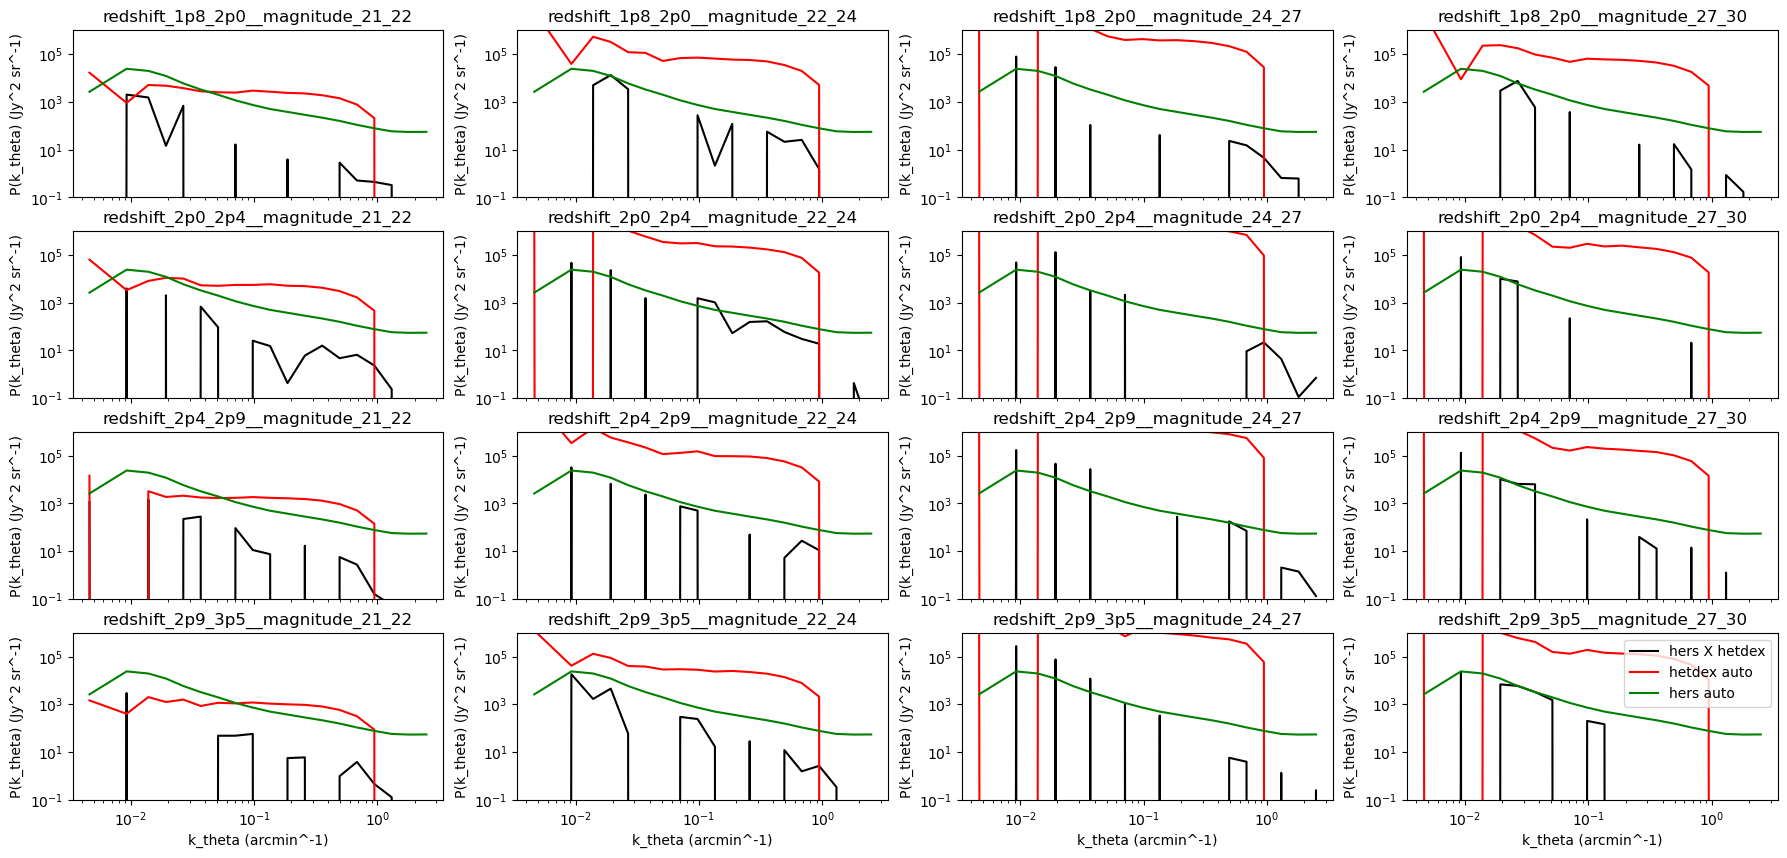

In [245]:
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
fig, axs = plt.subplots(4, 4, figsize=(22, 10))
for wv, pks in pk_dict.items():
    for i, pk_bin in enumerate(pks):
        ii = i//4
        iii = np.mod(i,4)
        axs[ii,iii].plot(k_theta, np.matmul(pks[pk_bin]['pk_hers_x_hetdex'], hers_x_hetdex_mkk), c='k', label='hers X hetdex');
        axs[ii,iii].plot(k_theta, np.matmul(pks[pk_bin]['pk_hetdex'], hetdex_mkk), c='r', label='hetdex auto')
        #axs[ii,iii].plot(k_theta, np.matmul(pk_hers, hers_mkk), c='g', label='hers auto')
        axs[ii,iii].plot(k_theta,  pk_hers, c='g', label='hers auto')
        axs[ii,iii].set_ylim([1e-1,1e6])
        #axs[ii,iii].set_ylim([1e3,4e5])
        #axs[ii,iii].set_xlim([0.005,2.05])
        axs[ii,iii].set_xscale('log')
        axs[ii,iii].set_yscale('log')
        axs[ii,iii].set_title(pk_bin)
        axs[ii,iii].set_ylabel('P(k_theta) (Jy^2 sr^-1)')
        
        if ii < 3:
            axs[ii,iii].set_xticklabels([])
        else:
            axs[ii,iii].set_xlabel('k_theta (arcmin^-1)')
            
#        print(ii, iii, pk_bin)

plt.legend(loc='upper right');            


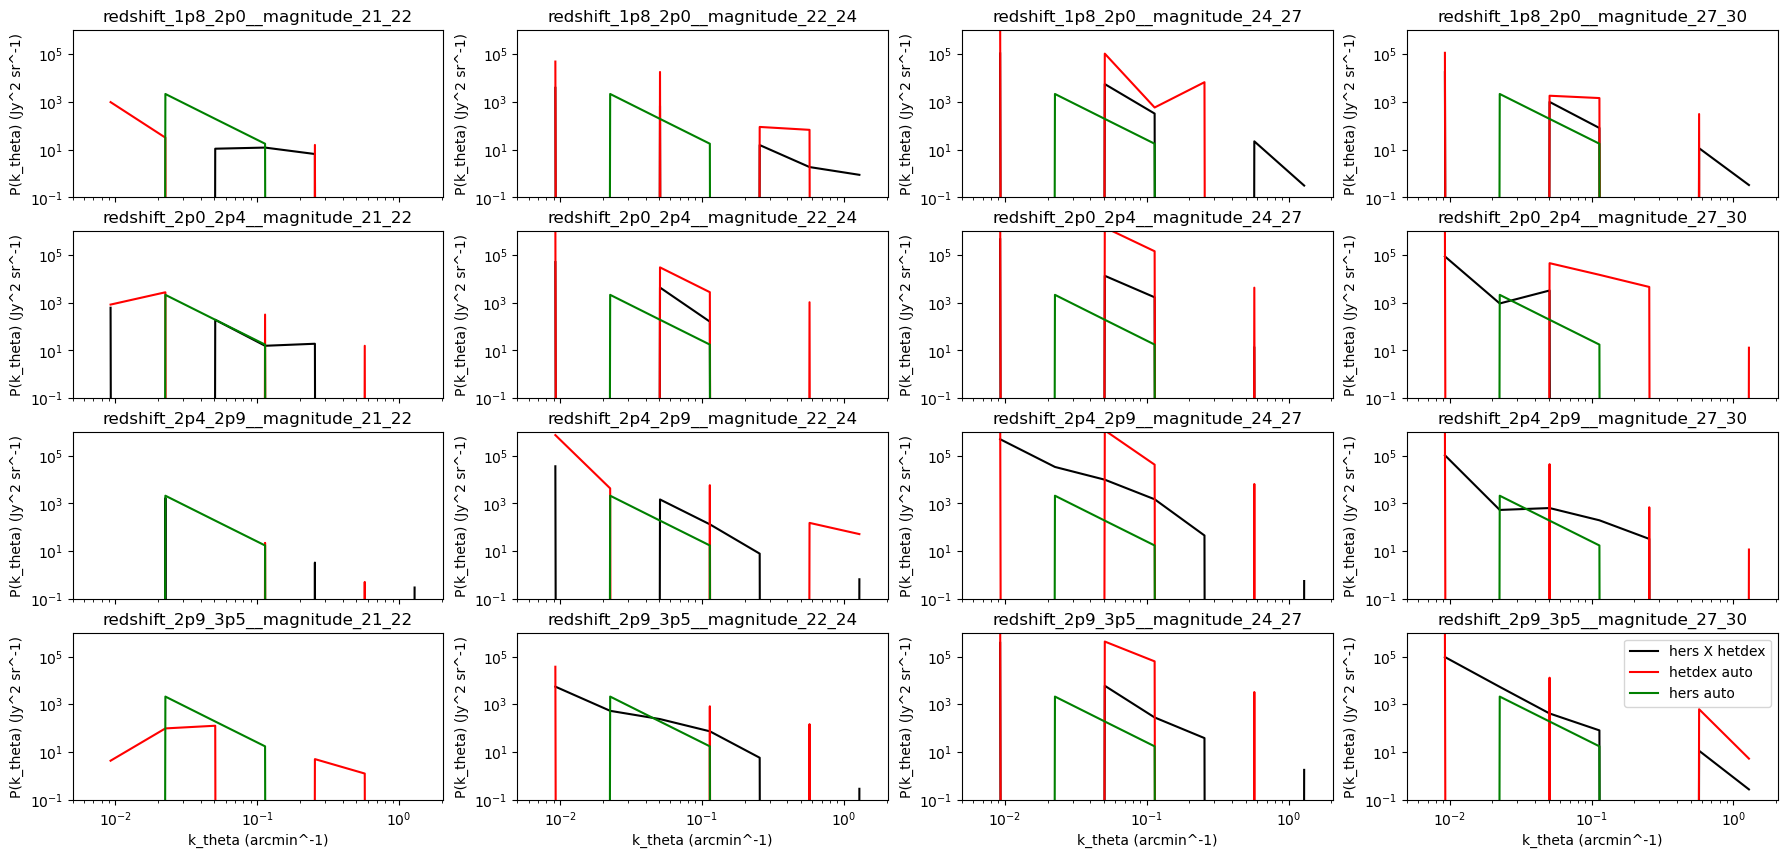

In [113]:
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
fig, axs = plt.subplots(4, 4, figsize=(22, 10))
for wv, pks in pk_dict.items():
    for i, pk_bin in enumerate(pks):
        ii = i//4
        iii = np.mod(i,4)
        axs[ii,iii].plot(k_theta, np.matmul(pks[pk_bin]['pk_hers_x_hetdex'], hers_x_hetdex_mkk), c='k', label='hers X hetdex');
        axs[ii,iii].plot(k_theta, np.matmul(pks[pk_bin]['pk_hetdex'], hetdex_mkk), c='r', label='hetdex auto')
        axs[ii,iii].plot(k_theta, np.matmul(pk_hers, hers_mkk), c='g', label='hers auto')
        axs[ii,iii].set_ylim([1e-1,1e6])
        axs[ii,iii].set_xlim([0.005,2.05])
        axs[ii,iii].set_xscale('log')
        axs[ii,iii].set_yscale('log')
        axs[ii,iii].set_title(pk_bin)
        axs[ii,iii].set_ylabel('P(k_theta) (Jy^2 sr^-1)')
        
        if ii < 3:
            axs[ii,iii].set_xticklabels([])
        else:
            axs[ii,iii].set_xlabel('k_theta (arcmin^-1)')
            
#        print(ii, iii, pk_bin)

plt.legend(loc='upper right');            


## Hetdex

In [71]:
hetdex, hd_hetdex = fits.getdata(hetdex_path, 0, header=True)

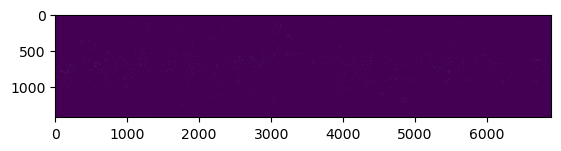

In [72]:
plt.imshow(hetdex);

In [73]:
#fft_hers_x_hetdex = np.real(np.fft.fft2(hers)*np.fft.fft2(hetdex))
#fft_hers_x_hetdex = np.real(np.fft.fft2(hers)*np.conj(np.fft.fft2(hetdex))) 
#fft_hers_x_hetdex = get_twod_fft(hers * hers_mask, map_two=hetdex * hetdex_mask)
fft_hers_x_hetdex = get_twod_fft(hers, map_two=hetdex, pix_arcsec=12)
#hdu = fits.PrimaryHDU(fft_hers_x_hetdex, header=hd_hers)
if write_maps:
    hdu = fits.PrimaryHDU(shift_twod(fft_hers_x_hetdex,shape_psw[0]/2,shape_psw[1]/2), header=hd_hers)
    hdul = fits.HDUList([hdu])
    hdul.writeto(os.path.join(path_hetdex_layers, 'hersXhetdex_fft_plw.fits'), overwrite=True)

In [74]:
np.shape(fft_hers_x_hetdex)

(1425, 6891)

In [60]:
fft_hers = get_twod_fft(hers, pix_arcsec=12)
fft_hetdex = get_twod_fft(hetdex, pix_arcsec=12)

In [61]:
ell_bins = get_ell_bins(hers, 12, deltal=deltal, width=width)

In [62]:
pk = bin_in_rings(fft_hers_x_hetdex, ell_bins, dist_psw)
pk_hers = bin_in_rings(fft_hers, ell_bins, dist_psw)
pk_hetdex = bin_in_rings(fft_hetdex, ell_bins, dist_psw)

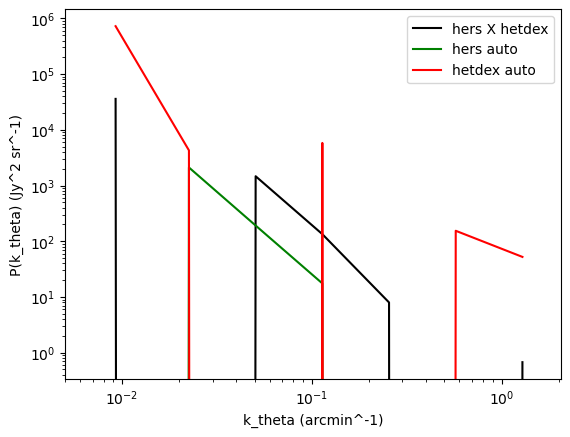

In [63]:
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
#plt.plot(k_theta, pk);
plt.plot(k_theta, np.matmul(pk, hers_x_hetdex_mkk), c='k', label='hers X hetdex');
plt.plot(k_theta, np.matmul(pk_hers, hers_mkk), c='g', label='hers auto')
plt.plot(k_theta,  np.matmul(pk_hetdex, hetdex_mkk), c='r', label='hetdex auto')
plt.xlim([0.005,2.05])
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right');
plt.xlabel('k_theta (arcmin^-1)');
plt.ylabel('P(k_theta) (Jy^2 sr^-1)');

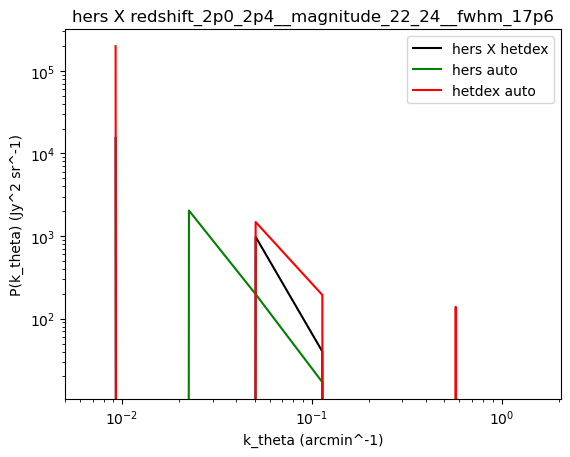

In [43]:
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
#plt.plot(k_theta, pk);
plt.plot(k_theta, np.matmul(pk, hers_x_hetdex_mkk), c='k', label='hers X hetdex');
plt.plot(k_theta, np.matmul(pk_hers, hers_mkk), c='g', label='hers auto')
plt.plot(k_theta,  np.matmul(pk_hetdex, hetdex_mkk), c='r', label='hetdex auto')
plt.xlim([0.005,2.05])
plt.title('hers X {}'.format(hetdex_maps[name]))
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right');
plt.xlabel('k_theta (arcmin^-1)');
plt.ylabel('P(k_theta) (Jy^2 sr^-1)');

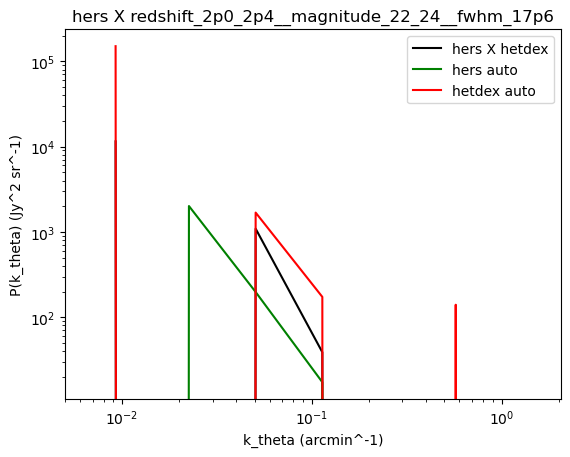

In [111]:
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
#plt.plot(k_theta, pk);
plt.plot(k_theta, np.matmul(pk, hers_x_hetdex_mkk), c='k', label='hers X hetdex');
plt.plot(k_theta, np.matmul(pk_hers, hers_mkk), c='g', label='hers auto')
plt.plot(k_theta,  np.matmul(pk_hetdex, hetdex_mkk), c='r', label='hetdex auto')
plt.xlim([0.005,2.05])
plt.title('hers X {}'.format(hetdex_maps[name]))
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right');
plt.xlabel('k_theta (arcmin^-1)');
plt.ylabel('P(k_theta) (Jy^2 sr^-1)');

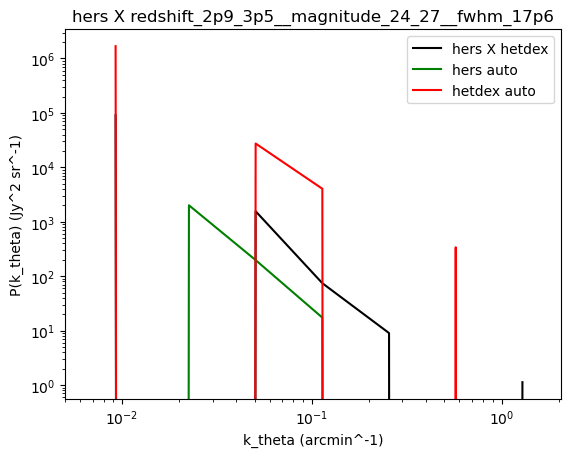

In [61]:
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
#plt.plot(k_theta, pk);
plt.plot(k_theta, np.matmul(pk, hers_x_hetdex_mkk), c='k', label='hers X hetdex');
plt.plot(k_theta, np.matmul(pk_hers, hers_mkk), c='g', label='hers auto')
plt.plot(k_theta,  np.matmul(pk_hetdex, hetdex_mkk), c='r', label='hetdex auto')
plt.xlim([0.005,2.05])
plt.title('hers X {}'.format(hetdex_maps[name]))
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right');
plt.xlabel('k_theta (arcmin^-1)');
plt.ylabel('P(k_theta) (Jy^2 sr^-1)');

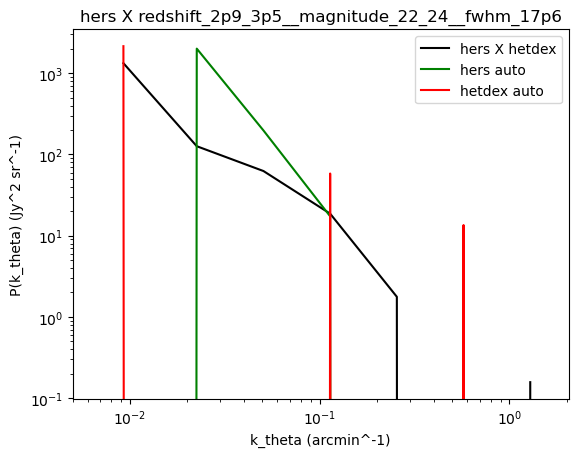

In [51]:
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
#plt.plot(k_theta, pk);
plt.plot(k_theta, np.matmul(pk, hers_x_hetdex_mkk), c='k', label='hers X hetdex');
plt.plot(k_theta, np.matmul(pk_hers, hers_mkk), c='g', label='hers auto')
plt.plot(k_theta,  np.matmul(pk_hetdex, hetdex_mkk), c='r', label='hetdex auto')
plt.xlim([0.005,2.05])
plt.title('hers X {}'.format(hetdex_maps[name]))
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right');
plt.xlabel('k_theta (arcmin^-1)');
plt.ylabel('P(k_theta) (Jy^2 sr^-1)');

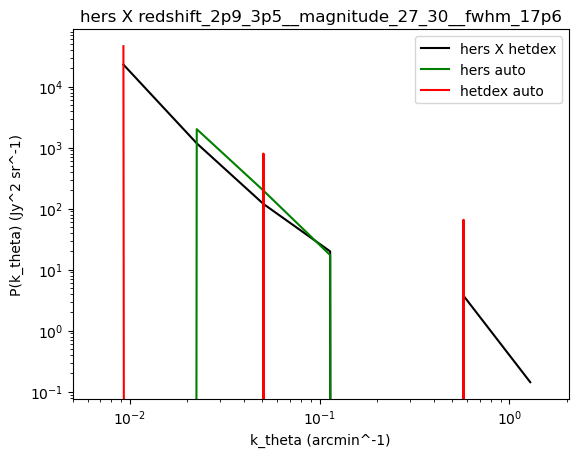

In [71]:
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
#plt.plot(k_theta, pk);
plt.plot(k_theta, np.matmul(pk, hers_x_hetdex_mkk), c='k', label='hers X hetdex');
plt.plot(k_theta, np.matmul(pk_hers, hers_mkk), c='g', label='hers auto')
plt.plot(k_theta,  np.matmul(pk_hetdex, hetdex_mkk), c='r', label='hetdex auto')
plt.xlim([0.005,2.05])
plt.title('hers X {}'.format(hetdex_maps[name]))
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right');
plt.xlabel('k_theta (arcmin^-1)');
plt.ylabel('P(k_theta) (Jy^2 sr^-1)');

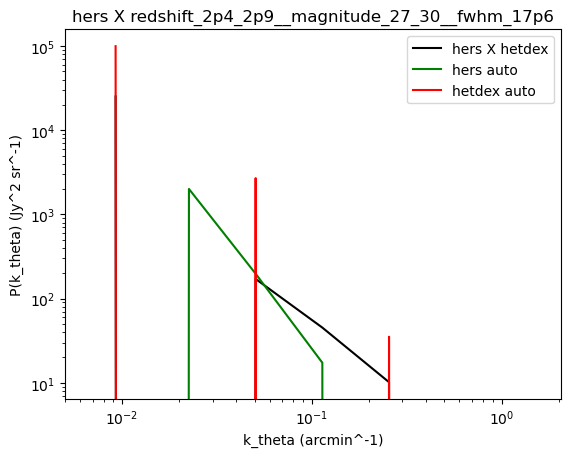

In [81]:
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
#plt.plot(k_theta, pk);
plt.plot(k_theta, np.matmul(pk, hers_x_hetdex_mkk), c='k', label='hers X hetdex');
plt.plot(k_theta, np.matmul(pk_hers, hers_mkk), c='g', label='hers auto')
plt.plot(k_theta,  np.matmul(pk_hetdex, hetdex_mkk), c='r', label='hetdex auto')
plt.xlim([0.005,2.05])
plt.title('hers X {}'.format(hetdex_maps[name]))
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right');
plt.xlabel('k_theta (arcmin^-1)');
plt.ylabel('P(k_theta) (Jy^2 sr^-1)');

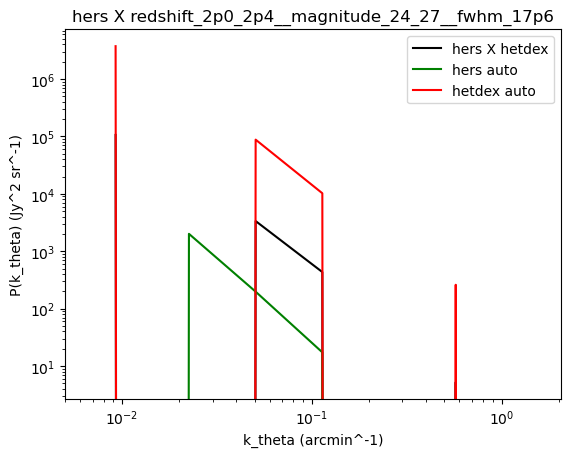

In [41]:
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
#plt.plot(k_theta, pk);
plt.plot(k_theta, np.matmul(pk, hers_x_hetdex_mkk), c='k', label='hers X hetdex');
plt.plot(k_theta, np.matmul(pk_hers, hers_mkk), c='g', label='hers auto')
plt.plot(k_theta,  np.matmul(pk_hetdex, hetdex_mkk), c='r', label='hetdex auto')
plt.xlim([0.005,2.05])
plt.title('hers X {}'.format(hetdex_maps[name]))
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right');
plt.xlabel('k_theta (arcmin^-1)');
plt.ylabel('P(k_theta) (Jy^2 sr^-1)');

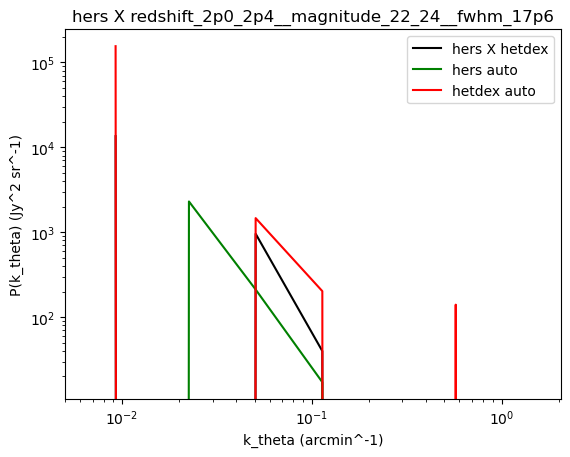

In [46]:
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
#plt.plot(k_theta, pk);
plt.plot(k_theta, np.matmul(pk, hers_x_hetdex_mkk), c='k', label='hers X hetdex');
plt.plot(k_theta, np.matmul(pk_hers, hers_mkk), c='g', label='hers auto')
plt.plot(k_theta,  np.matmul(pk_hetdex, hetdex_mkk), c='r', label='hetdex auto')
plt.xlim([0.005,2.05])
plt.title('hers X {}'.format(hetdex_maps[name]))
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right');
plt.xlabel('k_theta (arcmin^-1)');
plt.ylabel('P(k_theta) (Jy^2 sr^-1)');

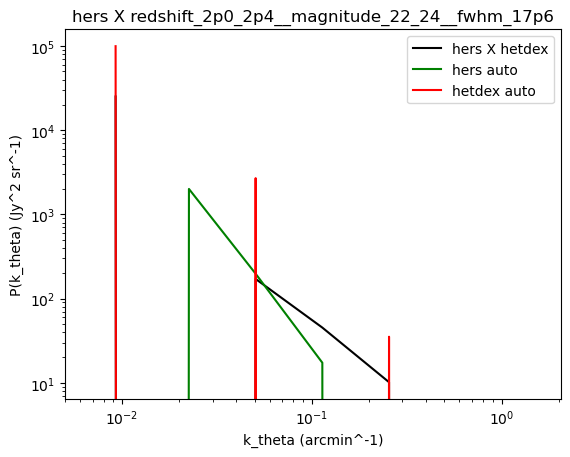

In [91]:
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
#plt.plot(k_theta, pk);
plt.plot(k_theta, np.matmul(pk, hers_x_hetdex_mkk), c='k', label='hers X hetdex');
plt.plot(k_theta, np.matmul(pk_hers, hers_mkk), c='g', label='hers auto')
plt.plot(k_theta,  np.matmul(pk_hetdex, hetdex_mkk), c='r', label='hetdex auto')
plt.xlim([0.005,2.05])
plt.title('hers X {}'.format(hetdex_maps[name]))
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right');
plt.xlabel('k_theta (arcmin^-1)');
plt.ylabel('P(k_theta) (Jy^2 sr^-1)');

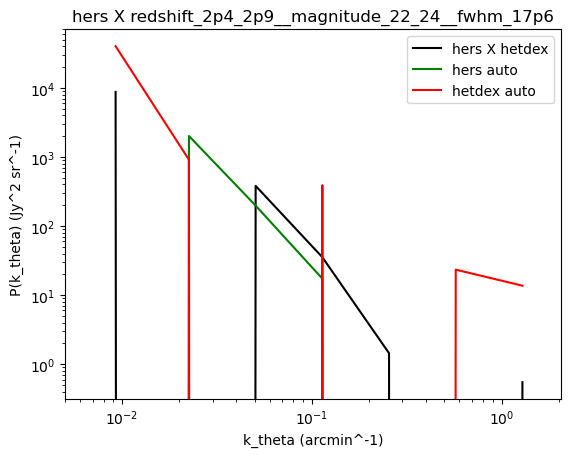

In [101]:
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
#plt.plot(k_theta, pk);
plt.plot(k_theta, np.matmul(pk, hers_x_hetdex_mkk), c='k', label='hers X hetdex');
plt.plot(k_theta, np.matmul(pk_hers, hers_mkk), c='g', label='hers auto')
plt.plot(k_theta,  np.matmul(pk_hetdex, hetdex_mkk), c='r', label='hetdex auto')
plt.xlim([0.005,2.05])
plt.title('hers X {}'.format(hetdex_maps[name]))
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right');
plt.xlabel('k_theta (arcmin^-1)');
plt.ylabel('P(k_theta) (Jy^2 sr^-1)');

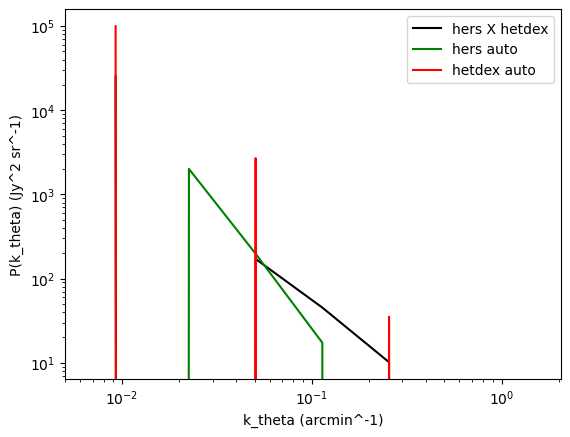

In [90]:
k_theta = ell_to_k((ell_bins[1:]+ell_bins[0:-1])/2)
#plt.plot(k_theta, pk);
plt.plot(k_theta, np.matmul(pk, hers_x_hetdex_mkk), c='k', label='hers X hetdex');
plt.plot(k_theta, np.matmul(pk_hers, hers_mkk), c='g', label='hers auto')
plt.plot(k_theta,  np.matmul(pk_hetdex, hetdex_mkk), c='r', label='hetdex auto')
plt.xlim([0.005,2.05])
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right');
plt.xlabel('k_theta (arcmin^-1)');
plt.ylabel('P(k_theta) (Jy^2 sr^-1)');

Get ell-bin 1534.0 to 2728.4
hers_mode_1534-2728_fourier_plw.fits


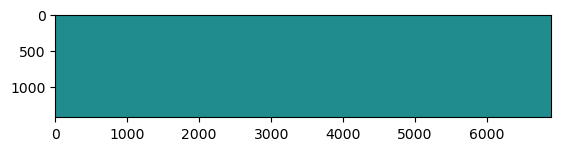

In [229]:
iell = 7
print('Get ell-bin {0:0.1f} to {1:0.1f}'.format( ell_bins[iell], ell_bins[iell+1]))
#ind_not_ring = (dist_psw < 50) | (dist_psw >= 100)
ind_not_ring = (dist_psw < ell_bins[iell]) | (dist_psw >= ell_bins[iell+1])
map_ring = np.ones_like(hers)*np.random.normal(size=shape_psw)
map_ring[ind_not_ring]=0
plt.imshow(shift_twod(map_ring,shape_psw[0]/2,shape_psw[1]/2));
hdu = fits.PrimaryHDU(shift_twod(map_ring,shape_psw[0]/2,shape_psw[1]/2), header=hd_hers)
hdul = fits.HDUList([hdu])
name = 'hers_mode_{0:0.0f}-{1:0.0f}_fourier_plw.fits'.format(ell_bins[iell], ell_bins[iell+1])
print(name)
hdul.writeto(os.path.join(path_hetdex_layers, name), overwrite=True)

hers_mode_1534-2728_plw.fits


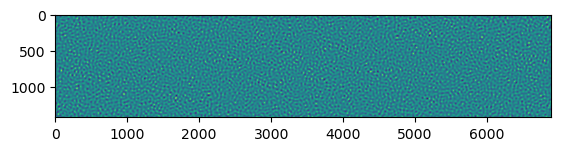

In [230]:
mode_map = np.real(np.fft.ifft2(map_ring))
plt.imshow(mode_map);
hdu = fits.PrimaryHDU(mode_map, header=hd_hers)
hdul = fits.HDUList([hdu])
name = 'hers_mode_{0:0.0f}-{1:0.0f}_plw.fits'.format(ell_bins[iell], ell_bins[iell+1])
print(name)
hdul.writeto(os.path.join(path_hetdex_layers, name), overwrite=True)

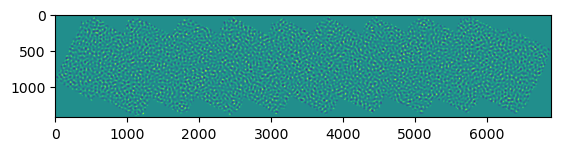

In [141]:
plt.imshow(mode_map*hers_mask);
hdu = fits.PrimaryHDU(mode_map*hers_mask, header=hd_hers)
hdul = fits.HDUList([hdu])
name = 'hers_masked_mode_{0:0.0f}-{1:0.0f}_plw.fits'.format(ell_bins[iell], ell_bins[iell+1])
hdul.writeto(os.path.join(path_hetdex_layers, name), overwrite=True)

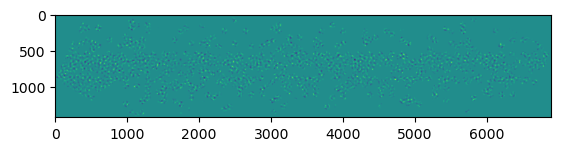

In [142]:
plt.imshow(mode_map*hetdex_mask);
hdu = fits.PrimaryHDU(mode_map*hetdex_mask, header=hd_hers)
hdul = fits.HDUList([hdu])
name = 'hetdex_masked_mode_{0:0.0f}-{1:0.0f}_plw.fits'.format(ell_bins[iell], ell_bins[iell+1])
hdul.writeto(os.path.join(path_hetdex_layers, name), overwrite=True)

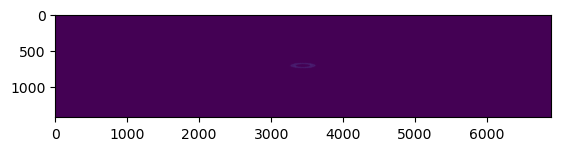

In [143]:
mask_mkk = np.real(np.fft.fft2(mode_map * hers_mask)**2)
plt.imshow(shift_twod(mask_mkk,shape_psw[0]/2,shape_psw[1]/2));
hdu = fits.PrimaryHDU(shift_twod(mask_mkk,shape_psw[0]/2,shape_psw[1]/2), header=hd_hers)
hdul = fits.HDUList([hdu])
name = 'hers_masked_mode_{0:0.0f}-{1:0.0f}_fft_plw.fits'.format(ell_bins[iell], ell_bins[iell+1])
hdul.writeto(os.path.join(path_hetdex_layers, name), overwrite=True)

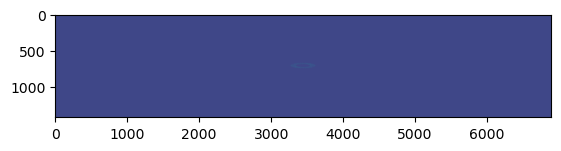

In [144]:
mask_mkk = np.real(np.fft.fft2(mode_map * hetdex_mask)**2)
plt.imshow(shift_twod(mask_mkk,shape_psw[0]/2,shape_psw[1]/2));
hdu = fits.PrimaryHDU(shift_twod(mask_mkk,shape_psw[0]/2,shape_psw[1]/2), header=hd_hers)
hdul = fits.HDUList([hdu])
name = 'hetdex_masked_mode_{0:0.0f}-{1:0.0f}_fft_plw.fits'.format(ell_bins[iell], ell_bins[iell+1])
hdul.writeto(os.path.join(path_hetdex_layers, name), overwrite=True)

hersXhetdex_masked_mode_1534-2728_fft_plw.fits


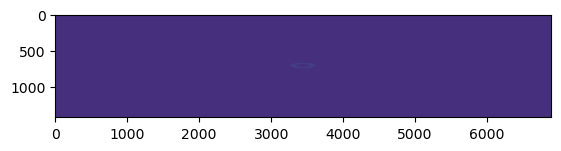

In [145]:
#mask_mkk = np.real(np.fft.fft2(mode_map * hers_mask)*np.fft.ifft2(mode_map * hetdex_mask))*(shape_psw[0]*shape_psw[1])
mask_mkk = np.real(np.fft.fft2(mode_map * hers_mask)*np.conj(np.fft.fft2(mode_map * hetdex_mask)))
plt.imshow(shift_twod(mask_mkk,shape_psw[0]/2,shape_psw[1]/2));
hdu = fits.PrimaryHDU(shift_twod(mask_mkk,shape_psw[0]/2,shape_psw[1]/2), header=hd_hers)
hdul = fits.HDUList([hdu])
name = 'hersXhetdex_masked_mode_{0:0.0f}-{1:0.0f}_fft_plw.fits'.format(ell_bins[iell], ell_bins[iell+1])
print(name)
hdul.writeto(os.path.join(path_hetdex_layers, name), overwrite=True)

In [146]:
pk_mask = bin_in_rings(mask_mkk, ell_bins, dist_psw)

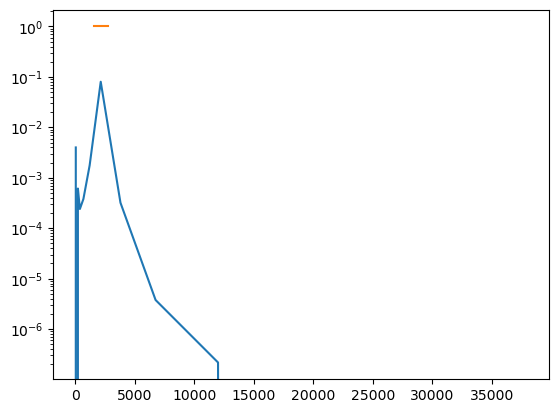

In [147]:
plt.plot((ell_bins[1:]+ell_bins[0:-1])/2, pk_mask);
plt.plot([ell_bins[iell],ell_bins[iell+1]],[1,1])
#plt.xscale('log')
plt.yscale('log')

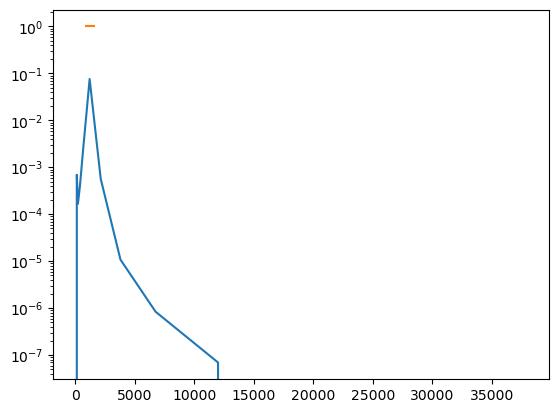

In [137]:
plt.plot((ell_bins[1:]+ell_bins[0:-1])/2, pk_mask);
plt.plot([ell_bins[iell],ell_bins[iell+1]],[1,1])
#plt.xscale('log')
plt.yscale('log')

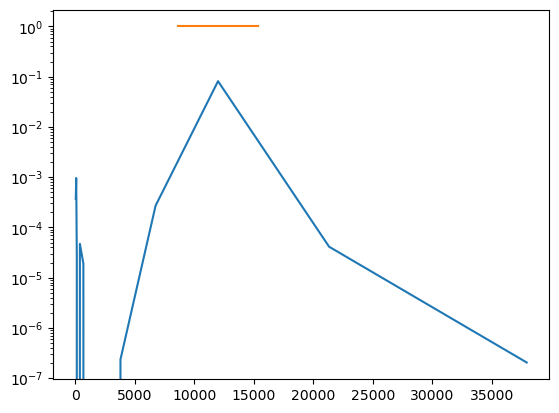

In [101]:
plt.plot((ell_bins[1:]+ell_bins[0:-1])/2, pk_mask);
plt.plot([ell_bins[iell],ell_bins[iell+1]],[1,1])
#plt.xscale('log')
plt.yscale('log')

In [35]:
dtor=0.017453292
xx=shape_psw[0]
xx=shape_psw[1]
yy=shape_psw[1]
pixsize=12
eff_side=np.sqrt(xx*yy)
eff_a=eff_side*(pixsize/3600.)*dtor
deltal=2.*np.pi/eff_a
print(deltal)

15.672616923143256


In [38]:
allmap_pixsize=12.
#l20=3456.0*2.
#deltal=100.
width=0.275
width=0.5
ell = linloggen(deltal,width)
k_theta_log = ell_to_k(ell)
print(ell)

[7.83630846e+00 2.35089254e+01 3.91815423e+01 7.08383800e+01
 1.28072449e+02 2.31548946e+02 4.18629570e+02 7.56862512e+02
 1.36837171e+03 2.47395150e+03 4.47278760e+03 8.08658896e+03
 1.46201713e+04 2.64325800e+04 4.77888576e+04]


In [222]:
dims=np.shape(hers_mask)

kx=np.arange(dims[0]/2+1)/(float(pixsize*dims[0]*np.pi/10800./60.))*2.*np.pi
kx=np.concatenate((kx,-kx[1:((1+dims[0])//2-1)][::-1]))
ky=np.arange(dims[1]/2+1)/(float(pixsize*dims[1]*np.pi/10800./60.))*2.*np.pi
ky=np.concatenate((ky,-ky[1:((1+dims[1])//2-1)][::-1]))

In [223]:
kx=(np.ones((len(ky),len(kx)))*kx)

In [224]:
ky=(np.ones((len(kx[1]),len(ky)))*ky).T

In [225]:
k=np.sqrt(kx**2+ky**2)

In [232]:
k

array([[  0.        ,  75.78947368, 151.57894737, ..., 227.36842105,
        151.57894737,  75.78947368],
       [ 15.67261646,  77.39299211, 152.3870342 , ..., 227.9079415 ,
        152.3870342 ,  77.39299211],
       [ 31.34523291,  82.01565672, 154.78598422, ..., 229.5188936 ,
        154.78598422,  82.01565672],
       ...,
       [ 47.01784937,  89.18925093, 158.70367181, ..., 232.17897633,
        158.70367181,  89.18925093],
       [ 31.34523291,  82.01565672, 154.78598422, ..., 229.5188936 ,
        154.78598422,  82.01565672],
       [ 15.67261646,  77.39299211, 152.3870342 , ..., 227.9079415 ,
        152.3870342 ,  77.39299211]])

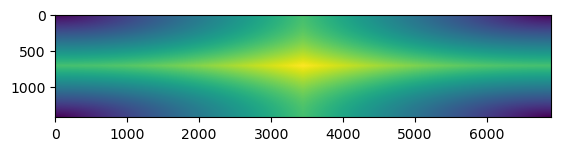

In [231]:
plt.imshow(k.T);

In [ ]:
bins=np.arange(np.min(k), np.max(k) + deltal, deltal)
plt.hist(k,bins=bins)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001783A825BD0> (for post_execute):


KeyboardInterrupt: 